# PA005: High Value Customer Identification(Insiders)

## Ciclo 00 - Planejamento - Método IOT

## Ciclo 01 - Métricas de Validação de Clusters
1. Feature Engineering:
    - Recência
    - Frequência
    - Monetização
2. Métricas de validação de Clustering:
    - WSS ( Within-Cluster Sum of Square )
    - SS ( Silhouette Score )
3. Cluster Analysis:
    - Plot 3D
    - Cluster Profile

## Ciclo 02 - Análise de Silhouette
1. Feature Engineering
    - Average Ticket
2. Análise de Silhouette
    - Silhouette Analysis
3. Cluster Visualization
    - UMAP
4. Cluster Análise de Perfil
    - Descrição dos centróides dos cluster

## Ciclo 03 - Statistical Descriptive
1. Análise Descritiva
    - Atributos numéricos
    - Atributos categóricos
2. Feature Engineering
    - Average Recency
    - Number of Returns
3. Data preparation
    - Standard Scaler

## 0.0. Planejamento da Solução (IOT)

### Input - Entrada
### O Problema de Negócio
1. Selecionar os mais valiosos clientes para formar o programa de fidelidade **"INSIDERS"**.
2. Conjunto de dados com as vendas de produtos durante 1 ano (Nov 2015 to Dec 2017).

### Output - Saída
1. A indicação de pessoas para fazer parte do programa de fidelidade **"INSIDERS"**.
2. Relatório com as respostas para as seguintes perguntas:
    - Quem são as pessoas elegíveis para participar do programa de Insiders?
    - Quantos clientes farão parte do grupo?
    - Quais as principais características desses clientes?
    - Qual a porcentagem de contribuição do faturamento, vinda do Insiders?
    - Qual a expectativa de faturamento desse grupo para os próximos meses?
    - Quais as condições para uma pessoa ser elegível ao Insiders?
    - Quais as condições para uma pessoa ser removida do Insiders?
    - Qual a garantia que o programa Insiders é o melhor que o restante da base?
    - Quais ações o time de marketing pode realizar para aumentar o faturamento?

### Tasks - Tarefas
1. **Quem são as pessoas elegíveis para participar do programa de Insiders?**
    - O que é ser elegível? O que são clientes de maior "valor"?
    - Faturamento:
        - Alto Ticket médio (média dos preços).
        - Alto LTV (life time value).
        - Baixa recência ou Alta frequência (tempo entre as compras).
        - Alto basket size (qtd média de produtos comprados).
        - Baixa probabilidade de Churn.
        - Alta previsão de LTV.
        - Alta propensão de compra.

    - Custo:
        - Baixa taxa de devolução.

    - Experiência de compra:
        - Média alta das avaliações.

2. **Quantos clientes farão parte do grupo?**
    - Número total de clientes.
    - % do grupo Insiders.

3. **Quais as principais características desses clientes?**
    - Escrever os principais atributos dos clientes:
        - Idade.
        - País.
        - Salário.

    - Escrever os principais comportamentos de compra dos clients (métricas de negócio):
        - Vide acima.

4. **Qual a porcentagem de contribuição do faturamento, vinda do Insiders?**
    - Calcular o faturamento total da empresa durante o ano.
    - Calcular o faturamento (%) apenas do cluster Insiders.

5. **Qual a expectativa de faturamento desse grupo para os próximos meses?**
    - Cálculo do LTV do grupo Insiders.
    - Séries Temporais (ARMA, ARIMA, HoltWinter, etc).

6. **Quais as condições para uma pessoa ser elegível ao Insiders?**
    - Qual o período de avaliação?
    - O "desempenho" do cliente está próximo da média do cluster Insiders.

7. **Quais as condições para uma pessoa ser removida do Insiders?**
    - O "desempenho" do cliente não está mais próximo da média do cluster Insiders.

8. **Qual a garantia que o programa Insiders é melhor que o restante da base?**
    - Teste de Hipóteses
    - Teste A/B

9. **Quais ações o time de marketing pode realizar para aumentar o faturamento?**
    - Desconto
    - Preferência de Compra
    - Produtos exclusivos

# <font color = 'red'> 0.0. Imports </font>

In [134]:
import pandas as pd
import numpy as np
import seaborn as sns
import umap.umap_ as umap
import re

from IPython.display import HTML
from matplotlib import pyplot as plt
from matplotlib import cm
from ydata_profiling import ProfileReport
from plotly import express as px
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

from sklearn import cluster as c
from sklearn import metrics as m
from sklearn import ensemble as en
from sklearn import preprocessing as pp
from sklearn import decomposition as dd
from sklearn import manifold as mn
from sklearn import mixture as mx
from sklearn.manifold import TSNE
from sklearn import ensemble as en

from scipy.cluster import hierarchy as hc

## 0.1. Helper Functions

In [3]:
def jupyter_settings():
    %matplotlib inline
    # %pylab inline
    
    plt.style.use('ggplot')
    plt.rcParams['figure.figsize'] = [24, 9]
    plt.rcParams['font.size'] = 24
    
    display(HTML('<style>.container{width:100% !important;}</style>'))
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option('display.expand_frame_repr', False)
    
    sns.set()

jupyter_settings()

## 0.2. Load dataset

In [4]:
# load data
df_raw = pd.read_csv('../data/raw/data.csv', encoding = 'ISO-8859-1')

# <font color = 'red'> 1.0. Descrição dos Dados </font>

In [5]:
df1 = df_raw.copy()

## 1.1. Rename columns

In [6]:
cols_new = ['invoice_no', 'stock_code', 'description', 
            'quantity', 'invoice_date', 'unit_price', 
            'customer_id', 'country']
df1.columns = cols_new

## 1.2. Data dimensions

In [7]:
print('number of rows: {}'.format(df1.shape[0]))
print('number of columns: {}'.format(df1.shape[1]))

number of rows: 541909
number of columns: 8


## 1.3. Data types

In [8]:
df1.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
customer_id     float64
country          object
dtype: object

## 1.4. Check NA

In [9]:
df1.isna().sum()

invoice_no           0
stock_code           0
description       1454
quantity             0
invoice_date         0
unit_price           0
customer_id     135080
country              0
dtype: int64

## 1.5. Replace NA

In [10]:
df_missing = df1.loc[df1['customer_id'].isna(), :]
df_not_missing = df1.loc[~df1['customer_id'].isna(), :]

In [11]:
# create reference
df_backup = pd.DataFrame(df_missing['invoice_no'].drop_duplicates())
df_backup['customer_id'] = np.arange(19000, 19000 + len(df_backup), 1)

# merge original df with reference df
df1 = pd.merge(df1, df_backup, on = 'invoice_no', how = 'left')

# coalesce -> combine_firts()
df1['customer_id'] = df1['customer_id_x'].combine_first(df1['customer_id_y'])

# drop extra columns
df1 = df1.drop(columns = ['customer_id_x', 'customer_id_y'], axis = 1)

In [12]:
df1.isna().sum()

invoice_no         0
stock_code         0
description     1454
quantity           0
invoice_date       0
unit_price         0
country            0
customer_id        0
dtype: int64

## 1.6. Change dtypes

In [13]:
# invoice date
df1['invoice_date'] = pd.to_datetime(df1['invoice_date'], format='%m/%d/%Y %H:%M').dt.date
df1['invoice_date'] = pd.to_datetime(df1['invoice_date'])

# customer id
df1['customer_id'] = df1['customer_id'].astype('int64')
df1.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,country,customer_id
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01,2.55,United Kingdom,17850
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01,3.39,United Kingdom,17850
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01,2.75,United Kingdom,17850
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01,3.39,United Kingdom,17850
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01,3.39,United Kingdom,17850


In [14]:
df1.dtypes

invoice_no              object
stock_code              object
description             object
quantity                 int64
invoice_date    datetime64[ns]
unit_price             float64
country                 object
customer_id              int64
dtype: object

## 1.7. Descriptive statistics

In [15]:
num_attributes = df1.select_dtypes(include = ['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude = ['int64', 'float64', 'datetime64[ns]'])

### 1.7.1. Numerical Attributes

In [16]:
# central tendency - mean, median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# dispersion - desvio padrão, mínimo, máximo, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(np.min)).T
d3 = pd.DataFrame(num_attributes.apply(np.max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

# concatenate
m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,quantity,-80995.00,80995.0,161990.00,9.552250,3.00,218.080957,-0.264076,119769.160031
1,unit_price,-11062.06,38970.0,50032.06,4.611114,2.08,96.759764,186.506972,59005.719097
2,customer_id,12346.00,22709.0,10363.00,16688.840453,16249.00,2911.408666,0.487449,-0.804287


### Questões:
1. Quantidade negativa (devolução?)
2. Preço unitário igual a zero (promoção?)

### 1.7.2. Categorical Attributes

#### Invoice No

In [17]:
# invoices with letters and numbers -> this is a problem!
# identificação
df_letter_invoices = df1.loc[df1['invoice_no'].apply(lambda x: bool(re.search('[^0-9]+', x))), :]
df_letter_invoices.head()

print('Total number of invoices: {}'.format(len(df_letter_invoices)))
print('Total number of negative quantity: {}'.format(len(df_letter_invoices[df_letter_invoices['quantity'] < 0])))

Total number of invoices: 9291
Total number of negative quantity: 9288


#### Stock Code

In [18]:
# check stock codes only characters
df1.loc[df1['stock_code'].apply(lambda x: bool(re.search('^[a-zA-Z]+$', x))), 'stock_code'].unique()

array(['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY',
       'DCGSSGIRL', 'PADS', 'B', 'CRUK'], dtype=object)

#### Description

In [19]:
df1.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,country,customer_id
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01,2.55,United Kingdom,17850
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01,3.39,United Kingdom,17850
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01,2.75,United Kingdom,17850
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01,3.39,United Kingdom,17850
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01,3.39,United Kingdom,17850


#### Country

In [20]:
df1['country'].unique()

array(['United Kingdom', 'France', 'Australia', 'Netherlands', 'Germany',
       'Norway', 'EIRE', 'Switzerland', 'Spain', 'Poland', 'Portugal',
       'Italy', 'Belgium', 'Lithuania', 'Japan', 'Iceland',
       'Channel Islands', 'Denmark', 'Cyprus', 'Sweden', 'Austria',
       'Israel', 'Finland', 'Bahrain', 'Greece', 'Hong Kong', 'Singapore',
       'Lebanon', 'United Arab Emirates', 'Saudi Arabia',
       'Czech Republic', 'Canada', 'Unspecified', 'Brazil', 'USA',
       'European Community', 'Malta', 'RSA'], dtype=object)

In [21]:
df1['country'].value_counts(normalize = True).head()

United Kingdom    0.914320
Germany           0.017521
France            0.015790
EIRE              0.015124
Spain             0.004674
Name: country, dtype: float64

In [22]:
df1[['customer_id', 'country']].drop_duplicates().groupby('country').count().reset_index().sort_values('customer_id', ascending = False).head()

,country,customer_id
36,United Kingdom,7587
14,Germany,95
13,France,90
10,EIRE,44
31,Spain,31


# <font color = 'red'> 2.0. Filtragem de Variáveis </font>

In [23]:
df2 = df1.copy()

In [24]:
df2.dtypes

invoice_no              object
stock_code              object
description             object
quantity                 int64
invoice_date    datetime64[ns]
unit_price             float64
country                 object
customer_id              int64
dtype: object

In [25]:
# numerical attributes
df2 = df2.loc[df2['unit_price'] >= 0.04, :]

# categorical attributes
df2 = df2[~df2['stock_code'].isin(['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY', 'DCGSSGIRL', 'PADS', 'B', 'CRUK'])]

# description
df2 = df2.drop(columns='description', axis = 1)

# map
df2 = df2[~df2['country'].isin(['European Community', 'Unspecified'])]

# bad users
df2 = df2[~df2['customer_id'].isin([16446])]

# quantity
df2_returns = df2.loc[df1['quantity'] < 0, :]
df2_purchases = df2.loc[df1['quantity'] >= 0, :]

# <font color = 'red'> 3.0. Feature Engineering </font>

In [26]:
# Feature Ideas:

# Moving Average - 7d, 14d, 30d
# Quantidade de Compras por mês, antes do dia 15 e depois do dia 15
# Average Financial
# Basket Size * Price - Quantidade de preços por cesta

In [27]:
df3 = df2.copy()

## 3.1. Feature Creation

In [28]:
# data reference
df_ref = df3.drop(['invoice_no', 'stock_code', 'quantity', 
                'invoice_date', 'unit_price', 'country'], axis = 1).drop_duplicates(ignore_index = True)

### 3.1.1. Gross Revenue

In [29]:
# Gross Revenue (Faturamento) quantity * price
df2_purchases = df2_purchases.copy()
df2_purchases.loc[:, 'gross_revenue'] = df2_purchases.loc[:, 'quantity'] * df2_purchases.loc[:, 'unit_price']

# Monetary
df_monetary = df2_purchases.loc[:, ['customer_id', 'gross_revenue']].groupby('customer_id').sum().reset_index()
df_ref = pd.merge(df_ref, df_monetary, on = 'customer_id', how = 'left')
df_ref.isna().sum()

customer_id       0
gross_revenue    91
dtype: int64

### 3.1.2. Recency - Days from Last Purchase

In [30]:
# Recency - Last day purchase
df_recency = df2_purchases.loc[:, ['customer_id', 'invoice_date']].groupby('customer_id').max().reset_index()
df_recency['recency_days'] = (df2['invoice_date'].max() - df_recency['invoice_date']).dt.days
df_recency = df_recency[['customer_id', 'recency_days']].copy()
df_ref = pd.merge(df_ref, df_recency, on = 'customer_id', how = 'left' )
df_ref.isna().sum()


customer_id       0
gross_revenue    91
recency_days     91
dtype: int64

### 3.1.3. Qty. Purchased

In [31]:
# Frequência de compra
df_freq = (df2_purchases.loc[:, ['customer_id', 'invoice_no']].drop_duplicates()
        .groupby( 'customer_id' )
        .count()
        .reset_index()
        .rename(columns = {'invoice_no': 'qty_invoices'}))
df_ref = pd.merge(df_ref, df_freq, on = 'customer_id', how = 'left')
df_ref.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
qty_invoices     91
dtype: int64

### 3.1.4. Total Qty. Items Purchased

In [32]:
# Numero de produtos
df_freq = (df2_purchases.loc[:, ['customer_id', 'quantity']].groupby('customer_id').sum()
                                                        .reset_index()
                                                        .rename(columns={'quantity': 'qty_items'}))
df_ref = pd.merge(df_ref, df_freq, on='customer_id', how='left')
df_ref.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
qty_invoices     91
qty_items        91
dtype: int64

### 3.1.5. Qty of Products Purchased

In [33]:
# Numero de produtos
df_freq = (df2_purchases.loc[:, ['customer_id', 'stock_code']].groupby('customer_id' ).count()
                                                        .reset_index()
                                                        .rename(columns={'stock_code': 'qty_products'}))
df_ref = pd.merge(df_ref, df_freq, on='customer_id', how='left')
df_ref.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
qty_invoices     91
qty_items        91
qty_products     91
dtype: int64

### 3.1.6. Avg Ticket Value

In [34]:
# Avg Ticket
df_avg_ticket = (df2_purchases.loc[:, ['customer_id', 'gross_revenue']].groupby('customer_id')
                .mean()
                .reset_index()
                .rename(columns = {'gross_revenue':'avg_ticket'}))
df_ref = pd.merge(df_ref, df_avg_ticket, on = 'customer_id', how = 'left')
df_ref.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
qty_invoices     91
qty_items        91
qty_products     91
avg_ticket       91
dtype: int64

### 3.1.7. Average Recency Days

In [35]:
# Average recency days
df_aux = df2[['customer_id', 'invoice_date']].drop_duplicates().sort_values(['customer_id', 'invoice_date'], ascending = [False, False])
df_aux['next_customer_id'] = df_aux['customer_id'].shift() # next customer
df_aux['previous_date'] = df_aux['invoice_date'].shift() # next invoince date

df_aux['avg_recency_days'] = df_aux.apply(lambda x: (x['invoice_date'] - x['previous_date']).days if x['customer_id'] == x['next_customer_id'] else np.nan, axis=1)

df_aux = df_aux.drop(['invoice_date', 'next_customer_id', 'previous_date'], axis=1).dropna()

# average recency 
df_avg_recency_days = df_aux.groupby('customer_id').mean().reset_index()

# merge
df_ref = pd.merge(df_ref, df_avg_recency_days, on = 'customer_id', how = 'left')
df_ref.isna().sum()

customer_id            0
gross_revenue         91
recency_days          91
qty_invoices          91
qty_items             91
qty_products          91
avg_ticket            91
avg_recency_days    2816
dtype: int64

### 3.1.8. Frequency Purchases

In [36]:
df_aux = (df2_purchases[['customer_id', 'invoice_no', 'invoice_date']].drop_duplicates()
                                                            .groupby( 'customer_id')
                                                            .agg(max_ = ('invoice_date', 'max'), 
                                                                min_ = ('invoice_date', 'min'),
                                                                days_= ('invoice_date', lambda x: ((x.max() - x.min()).days ) + 1),
                                                                buy_ = ('invoice_no', 'count'))).reset_index()

# Frequency
df_aux['frequency'] = df_aux[['buy_', 'days_']].apply(lambda x: x['buy_'] / x['days_'] if  x['days_'] != 0 else 0, axis = 1)

# Merge
df_ref = pd.merge(df_ref, df_aux[['customer_id', 'frequency']], on = 'customer_id', how = 'left')
df_ref.isna().sum()

customer_id            0
gross_revenue         91
recency_days          91
qty_invoices          91
qty_items             91
qty_products          91
avg_ticket            91
avg_recency_days    2816
frequency             91
dtype: int64

### 3.1.9. Number of Returns

In [37]:
# returns
df_returns = df2_returns[['customer_id', 'quantity']].groupby('customer_id').sum().reset_index().rename(columns={'quantity':'qty_returns'})
df_returns['qty_returns'] = df_returns['qty_returns'] * -1

df_ref = pd.merge(df_ref, df_returns, how = 'left', on = 'customer_id')
df_ref.loc[df_ref['qty_returns'].isna(), 'qty_returns'] = 0

df_ref.isna().sum()

customer_id            0
gross_revenue         91
recency_days          91
qty_invoices          91
qty_items             91
qty_products          91
avg_ticket            91
avg_recency_days    2816
frequency             91
qty_returns            0
dtype: int64

### 3.1.10. Basket Size - Quantidade de Items por Cesta (Quantity)
- Invoice No = Compra = purchase
- Stock Code = Produto = Product
- Quantity = Item = Item

In [38]:
df_aux = (df2_purchases.loc[:, ['customer_id', 'invoice_no', 'quantity']].groupby('customer_id')
                                                                        .agg(n_purchase = ('invoice_no', 'nunique'), 
                                                                            n_products = ('quantity', 'sum'))
                                                                        .reset_index())

# calc
df_aux['avg_basket_size'] = df_aux['n_products'] / df_aux['n_purchase']

# merge
df_ref = pd.merge(df_ref, df_aux[['customer_id', 'avg_basket_size']], how = 'left', on = 'customer_id')
df_ref.isna().sum()

customer_id            0
gross_revenue         91
recency_days          91
qty_invoices          91
qty_items             91
qty_products          91
avg_ticket            91
avg_recency_days    2816
frequency             91
qty_returns            0
avg_basket_size       91
dtype: int64

### 3.2.0. Unique Basket Size - Quantidade de produtos distintos por compra

In [39]:
# Como se calcula essa feature?!

df_aux = (df2_purchases.loc[:, ['customer_id', 'invoice_no', 'stock_code']].groupby('customer_id' )
                                                                            .agg(n_purchase=('invoice_no', 'nunique'),
                                                                                n_products=('stock_code', 'nunique'))
                                                                            .reset_index())

# calculation
df_aux['avg_unique_basket_size'] = df_aux['n_products'] / df_aux['n_purchase']

# merge
df_ref = pd.merge(df_ref, df_aux[['customer_id', 'avg_unique_basket_size']], how = 'left', on = 'customer_id')
df_ref.isna().sum()

customer_id                  0
gross_revenue               91
recency_days                91
qty_invoices                91
qty_items                   91
qty_products                91
avg_ticket                  91
avg_recency_days          2816
frequency                   91
qty_returns                  0
avg_basket_size             91
avg_unique_basket_size      91
dtype: int64

In [40]:
df_ref.head()

,customer_id,gross_revenue,recency_days,qty_invoices,qty_items,qty_products,avg_ticket,avg_recency_days,frequency,qty_returns,avg_basket_size,avg_unique_basket_size
0,17850,5391.21,372.0,34.0,1733.0,297.0,18.152222,-35.500000,17.000000,40.0,50.970588,0.617647
1,13047,3232.59,56.0,9.0,1390.0,171.0,18.904035,-27.250000,0.028302,35.0,154.444444,11.666667
2,12583,6705.38,2.0,15.0,5028.0,232.0,28.902500,-23.187500,0.040323,50.0,335.200000,7.600000
3,13748,948.25,95.0,5.0,439.0,28.0,33.866071,-92.666667,0.017921,0.0,87.800000,4.800000
4,15100,876.00,333.0,3.0,80.0,3.0,292.000000,-8.600000,0.073171,22.0,26.666667,0.333333


# <font color = 'red'> 4.0. EDA (Exploratory Data Analysis) </font>

In [41]:
df4 = df_ref.dropna()
df4.isna().sum()

customer_id               0
gross_revenue             0
recency_days              0
qty_invoices              0
qty_items                 0
qty_products              0
avg_ticket                0
avg_recency_days          0
frequency                 0
qty_returns               0
avg_basket_size           0
avg_unique_basket_size    0
dtype: int64

## 4.1. Univariate Analysis

1. Clusters Coesos - Separados
2. Métricas:
    - Min, Máximo, Range (Dispersão)
    - Média e Mediana
    - Desvio Padrão e Variância
    - Coeficiente de Variação (CV)
    - Distribuição

**Investigar/Remover**

1. Gross Revenue - ok

In [42]:
profile = ProfileReport(df4)
profile.to_file('output_v2.html')

c:\Users\pgdem\anaconda3\envs\insiders\lib\site-packages\ydata_profiling\utils\dataframe.py:137: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns={"index": "df_index"}, inplace=True)


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

c:\Users\pgdem\anaconda3\envs\insiders\lib\site-packages\ydata_profiling\model\pandas\discretize_pandas.py:52: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  discretized_df.loc[:, column] = self._discretize_column(


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

### 4.1.1. Gross Revenue

In [43]:
df4.sort_values('gross_revenue', ascending=False).head()

,customer_id,gross_revenue,recency_days,qty_invoices,qty_items,qty_products,avg_ticket,avg_recency_days,frequency,qty_returns,avg_basket_size,avg_unique_basket_size
1017,14646,279138.02,1.0,72.0,196844.0,2060.0,135.503893,-7.844444,0.203390,288.0,2733.944444,9.708333
492,18102,259657.30,0.0,60.0,64124.0,431.0,602.453132,-14.680000,0.163043,0.0,1068.733333,2.500000
433,17450,194550.79,8.0,46.0,69993.0,337.0,577.302047,-12.821429,0.127778,952.0,1521.586957,2.695652
66,14911,140450.72,1.0,199.0,80263.0,5673.0,24.757751,-2.601399,0.533512,3332.0,403.331658,8.974874
1150,12415,124564.53,24.0,20.0,77373.0,713.0,174.704811,-20.866667,0.063694,427.0,3868.650000,22.150000


In [44]:
df3[df3['customer_id'] == 14646].head()

,invoice_no,stock_code,quantity,invoice_date,unit_price,country,customer_id
37952,539491,21981,12,2010-12-20,0.29,Netherlands,14646
37953,539491,21986,12,2010-12-20,0.29,Netherlands,14646
37954,539491,22720,2,2010-12-20,4.95,Netherlands,14646
37955,539491,21931,1,2010-12-20,1.95,Netherlands,14646
37956,539491,22613,2,2010-12-20,0.85,Netherlands,14646


### 4.1.2. Qty of Items

In [45]:
df4[df4['qty_items'] == 196844]

,customer_id,gross_revenue,recency_days,qty_invoices,qty_items,qty_products,avg_ticket,avg_recency_days,frequency,qty_returns,avg_basket_size,avg_unique_basket_size
1017,14646,279138.02,1.0,72.0,196844.0,2060.0,135.503893,-7.844444,0.20339,288.0,2733.944444,9.708333


In [46]:
df3[df3['customer_id'] == 14646].head()

,invoice_no,stock_code,quantity,invoice_date,unit_price,country,customer_id
37952,539491,21981,12,2010-12-20,0.29,Netherlands,14646
37953,539491,21986,12,2010-12-20,0.29,Netherlands,14646
37954,539491,22720,2,2010-12-20,4.95,Netherlands,14646
37955,539491,21931,1,2010-12-20,1.95,Netherlands,14646
37956,539491,22613,2,2010-12-20,0.85,Netherlands,14646


### 4.1.3. Qty of Products

In [47]:
df3[df3['customer_id'] == 17841].head()

,invoice_no,stock_code,quantity,invoice_date,unit_price,country,customer_id
1441,C536543,22632,-1,2010-12-01,2.10,United Kingdom,17841
1442,C536543,22355,-2,2010-12-01,0.85,United Kingdom,17841
2037,536557,21495,25,2010-12-01,0.42,United Kingdom,17841
2038,536557,46000R,2,2010-12-01,1.45,United Kingdom,17841
2039,536557,46000S,1,2010-12-01,1.45,United Kingdom,17841


### 4.1.4. Avg Ticket

In [48]:
df4[df4['avg_ticket'] == 4453.43]

,customer_id,gross_revenue,recency_days,qty_invoices,qty_items,qty_products,avg_ticket,avg_recency_days,frequency,qty_returns,avg_basket_size,avg_unique_basket_size
1262,15749,44534.3,235.0,3.0,18028.0,10.0,4453.43,-97.0,0.030612,9014.0,6009.333333,1.666667


In [49]:
df3[df3['customer_id'] == 15749].head()

,invoice_no,stock_code,quantity,invoice_date,unit_price,country,customer_id
52709,540815,85123A,1930,2011-01-11,2.55,United Kingdom,15749
52710,540815,21175,2000,2011-01-11,1.85,United Kingdom,15749
52711,540815,21108,3114,2011-01-11,2.10,United Kingdom,15749
52771,540818,47556B,1300,2011-01-11,2.55,United Kingdom,15749
52772,540818,48185,670,2011-01-11,6.75,United Kingdom,15749


### 4.1.5. Avg Ticket

In [50]:
# df4[df4['frequency'] == 56157.5]
# df3[df3['customer_id'] == 16446].head()

### 4.1.6 Frequency

In [51]:
df4[df4['frequency'] == 17]

,customer_id,gross_revenue,recency_days,qty_invoices,qty_items,qty_products,avg_ticket,avg_recency_days,frequency,qty_returns,avg_basket_size,avg_unique_basket_size
0,17850,5391.21,372.0,34.0,1733.0,297.0,18.152222,-35.5,17.0,40.0,50.970588,0.617647


In [52]:
df3[df3['customer_id'] == 17850].sort_values('quantity', ascending = False).head(30)

,invoice_no,stock_code,quantity,invoice_date,unit_price,country,customer_id
4528,536790,84406B,12,2010-12-02,2.75,United Kingdom,17850
4162,536750,71053,12,2010-12-02,3.39,United Kingdom,17850
3808,536685,85123A,12,2010-12-02,2.55,United Kingdom,17850
4526,536790,85123A,12,2010-12-02,2.95,United Kingdom,17850
4527,536790,71053,12,2010-12-02,3.39,United Kingdom,17850
3809,536685,71053,12,2010-12-02,3.39,United Kingdom,17850
4531,536790,37370,12,2010-12-02,1.06,United Kingdom,17850
4532,536790,21071,12,2010-12-02,1.06,United Kingdom,17850
4533,536790,21068,12,2010-12-02,1.06,United Kingdom,17850
290,536396,82494L,12,2010-12-01,2.55,United Kingdom,17850


### 4.1.7. Average Basket Size

In [53]:
# df4[df4['avg_basket_size'] == 48498.5]

## 4.2. Bivariate Analysis

In [54]:
cols = ['customer_id']
df42 = df4.drop(cols, axis=1)

<Figure size 2500x1200 with 0 Axes>

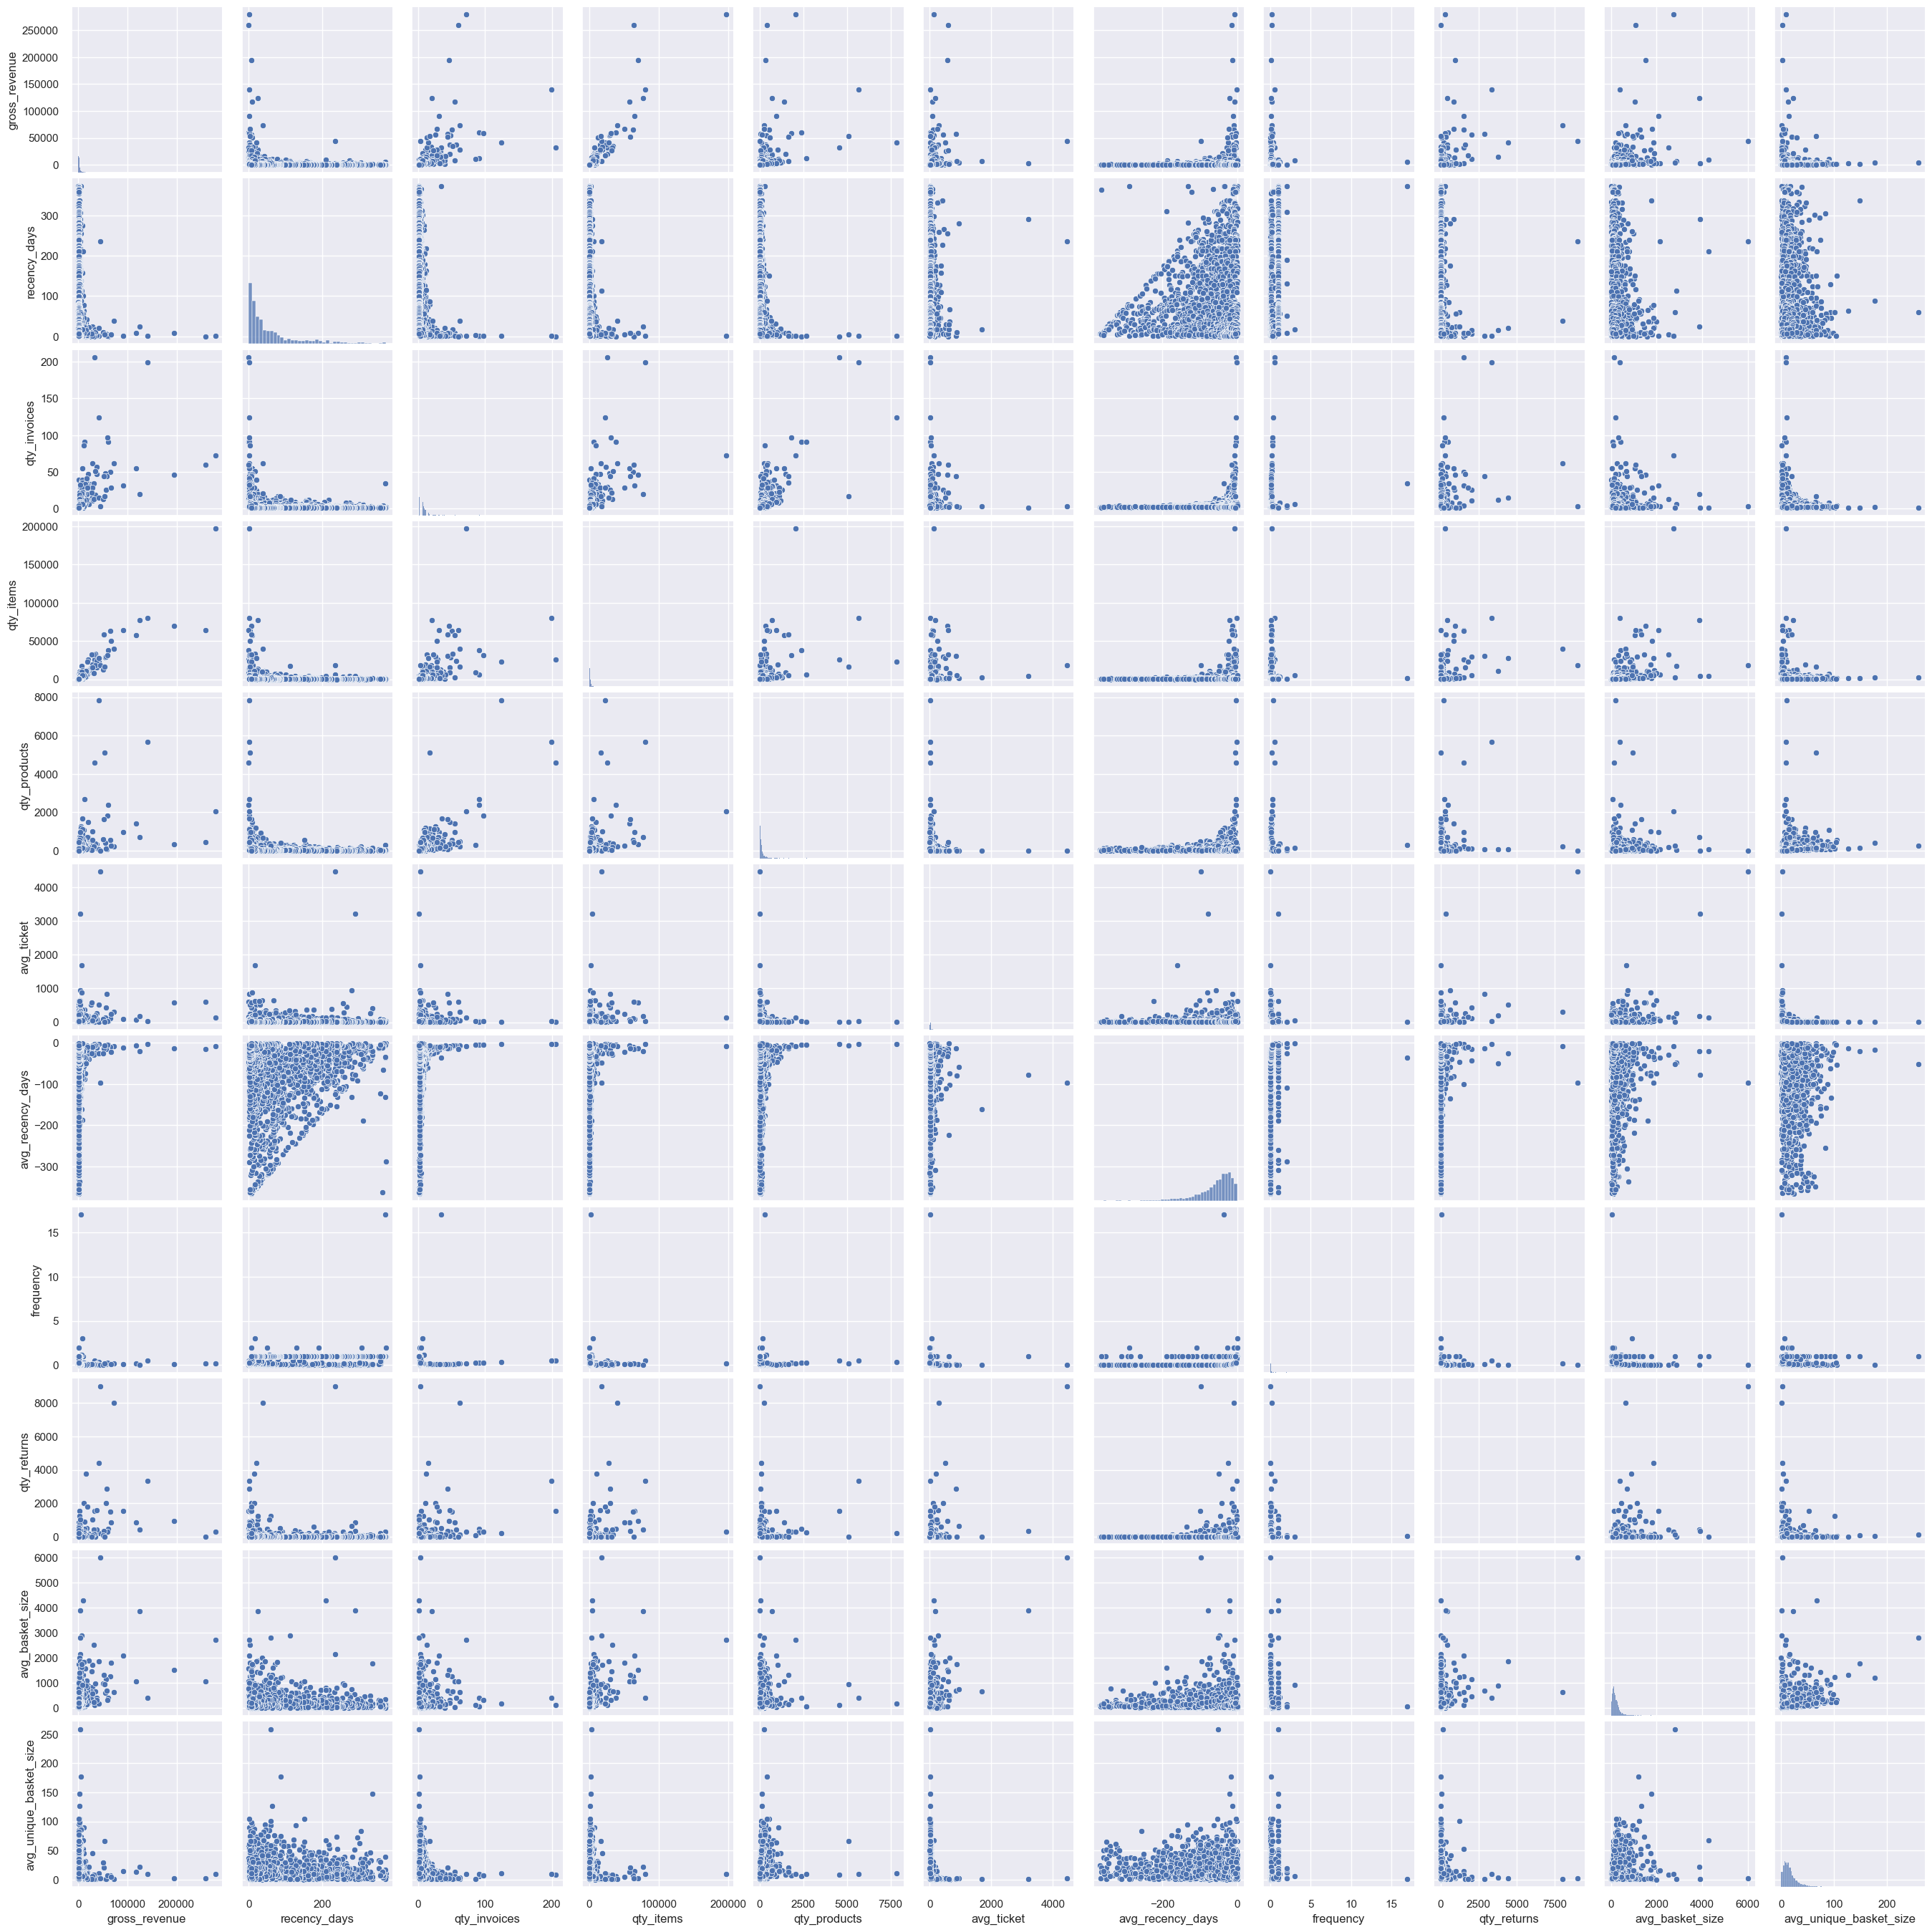

In [55]:
plt.figure(figsize=(25, 12))
sns.pairplot(df42)

**Notes**
1. Frequency has low variance
2. Avg Ticket has low variance

## 4.3. Estudo de Espaços

In [56]:
df43 = df4.drop(columns = ['customer_id'], axis = 1).copy()

In [57]:
mm = pp.MinMaxScaler()

df43['gross_revenue'] = mm.fit_transform(df43[['gross_revenue']])
df43['recency_days'] = mm.fit_transform(df43[['recency_days']])
df43['qty_invoices'] = mm.fit_transform(df43[['qty_invoices']])
df43['qty_items'] = mm.fit_transform(df43[['qty_items']])
df43['qty_products'] = mm.fit_transform(df43[['qty_products']])
df43['avg_ticket'] = mm.fit_transform(df43[['avg_ticket']])
df43['avg_recency_days'] = mm.fit_transform(df43[['avg_recency_days']])
df43['frequency'] = mm.fit_transform(df43[['frequency']])
df43['qty_returns'] = mm.fit_transform(df43[['qty_returns']])
df43['avg_basket_size'] = mm.fit_transform(df43[['avg_basket_size']])
df43['avg_unique_basket_size'] = mm.fit_transform(df43[['avg_unique_basket_size']])

X = df43.copy()

### 4.3.1. PCA - Principal Component Analysis

In [58]:
X.shape[1]

11

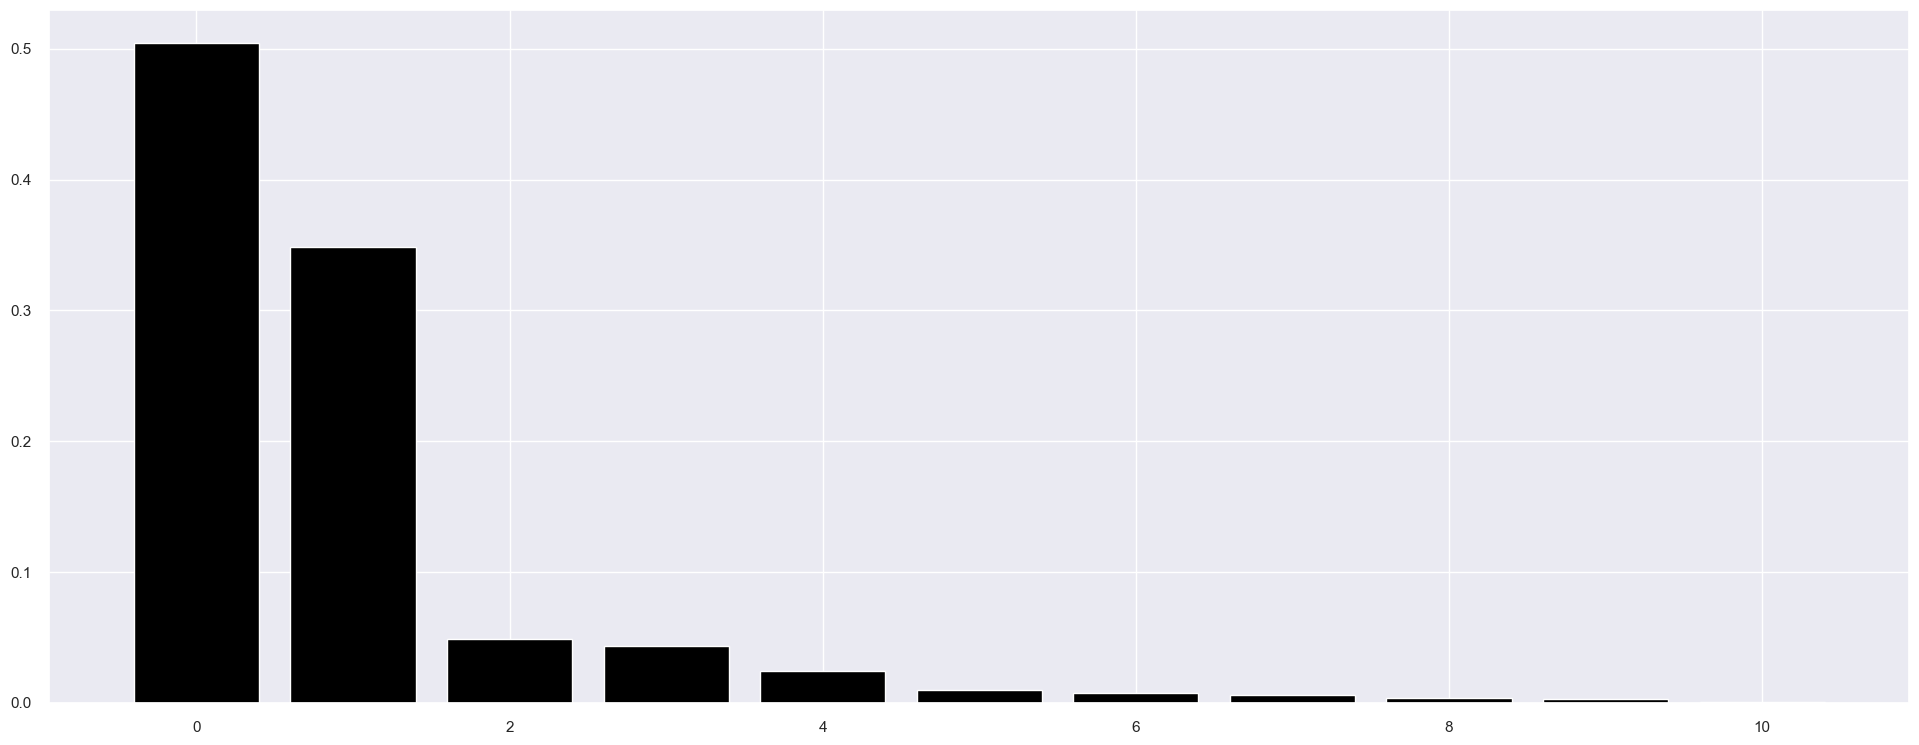

In [59]:
pca = dd.PCA(n_components = X.shape[1])
principal_components = pca.fit_transform(X)

# plot explained variable
features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_ratio_, color = 'black')

# pca component
df_pca = pd.DataFrame(principal_components)

<AxesSubplot: xlabel='0', ylabel='1'>

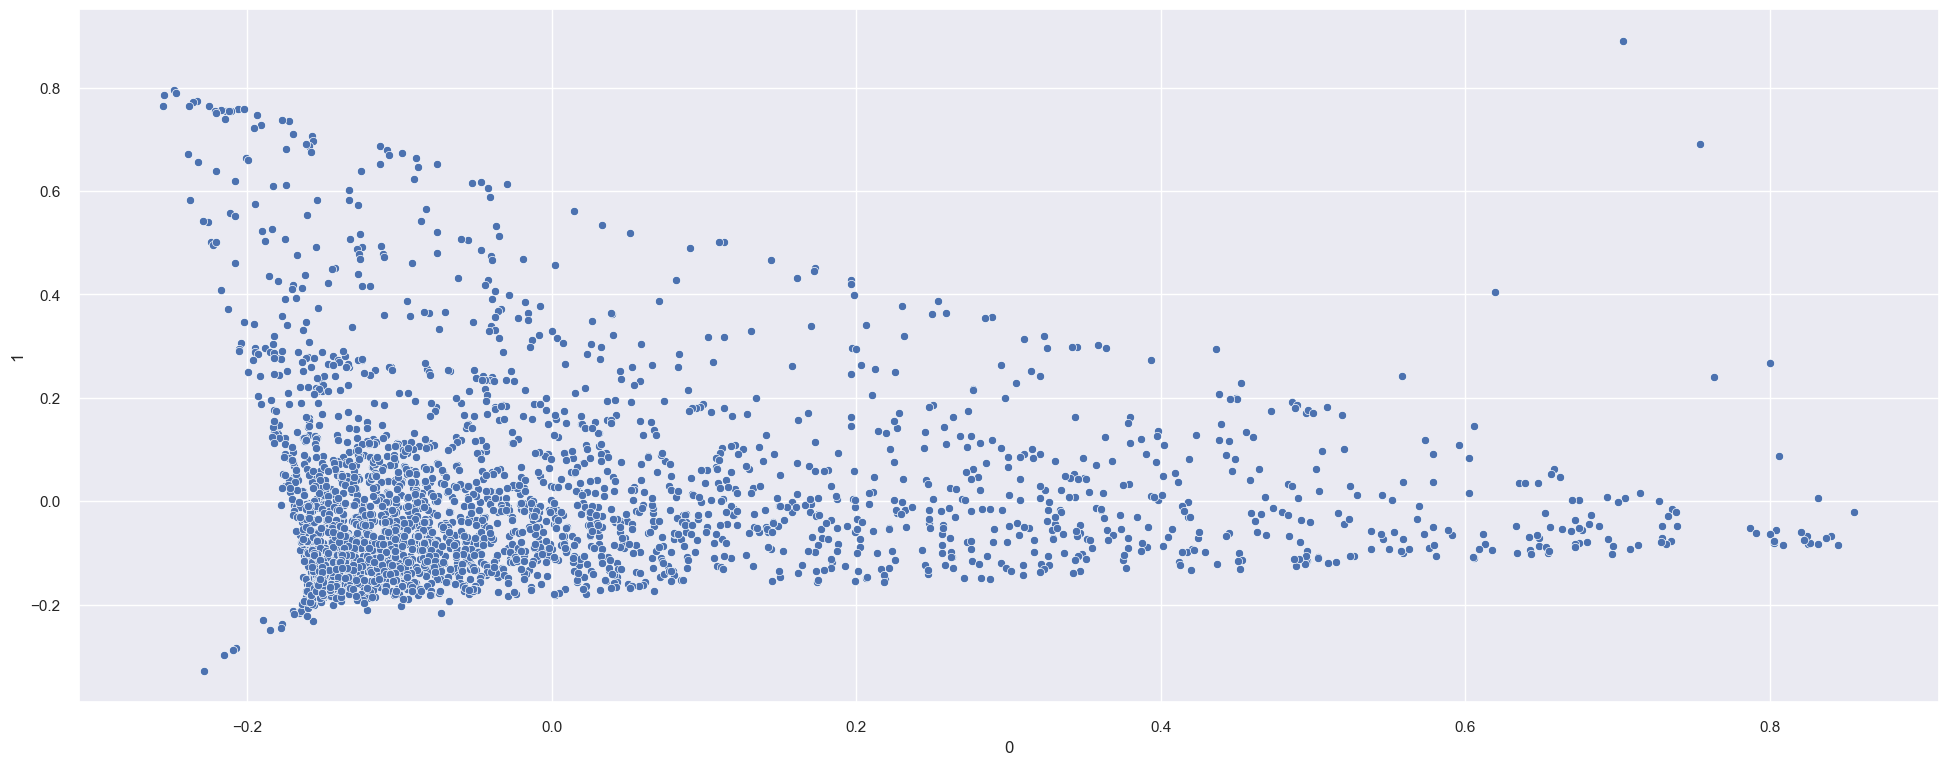

In [60]:
sns.scatterplot(x = 0, y = 1, data = df_pca)

### 4.3.2. UMAP - Uniform Manifold Approximation and Projection

<AxesSubplot: xlabel='embedding_x', ylabel='embedding_y'>

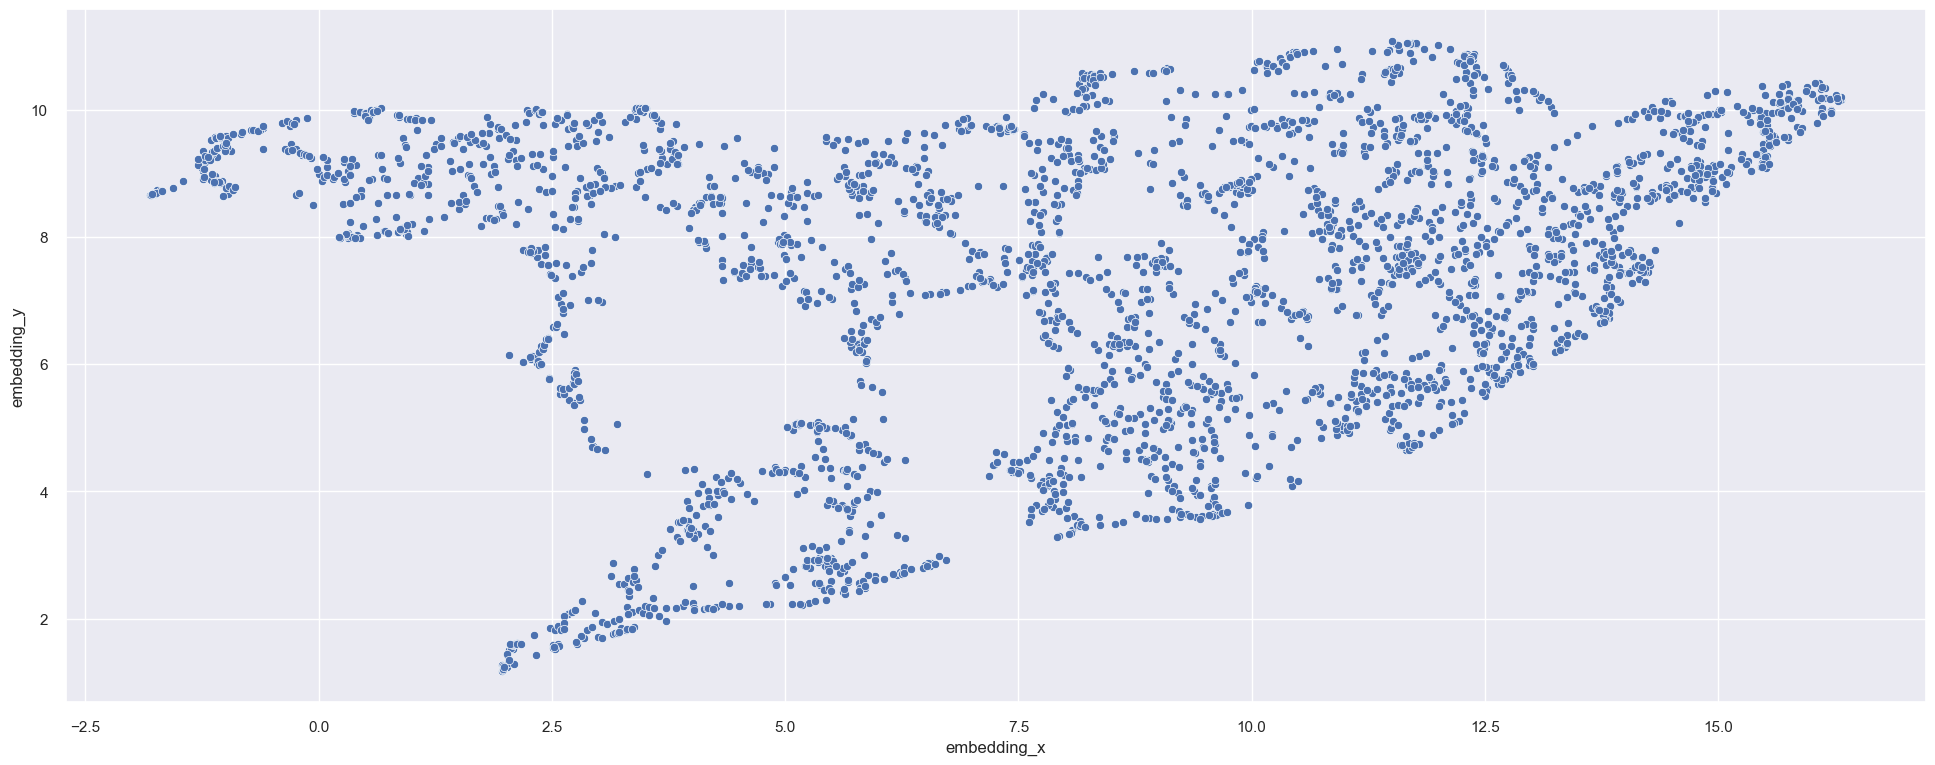

In [61]:
reducer = umap.UMAP(random_state = 42)
embedding = reducer.fit_transform(X)

# embedding
df_pca['embedding_x'] = embedding[:, 0]
df_pca['embedding_y'] = embedding[:, 1]

# plot UMAP
sns.scatterplot(x = 'embedding_x', y='embedding_y', data=df_pca)

### 4.3.3. t-SNE - t-Distributed Stochastic Neighbor Embedding

c:\Users\pgdem\anaconda3\envs\insiders\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\pgdem\anaconda3\envs\insiders\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


<AxesSubplot: xlabel='embedding_x', ylabel='embedding_y'>

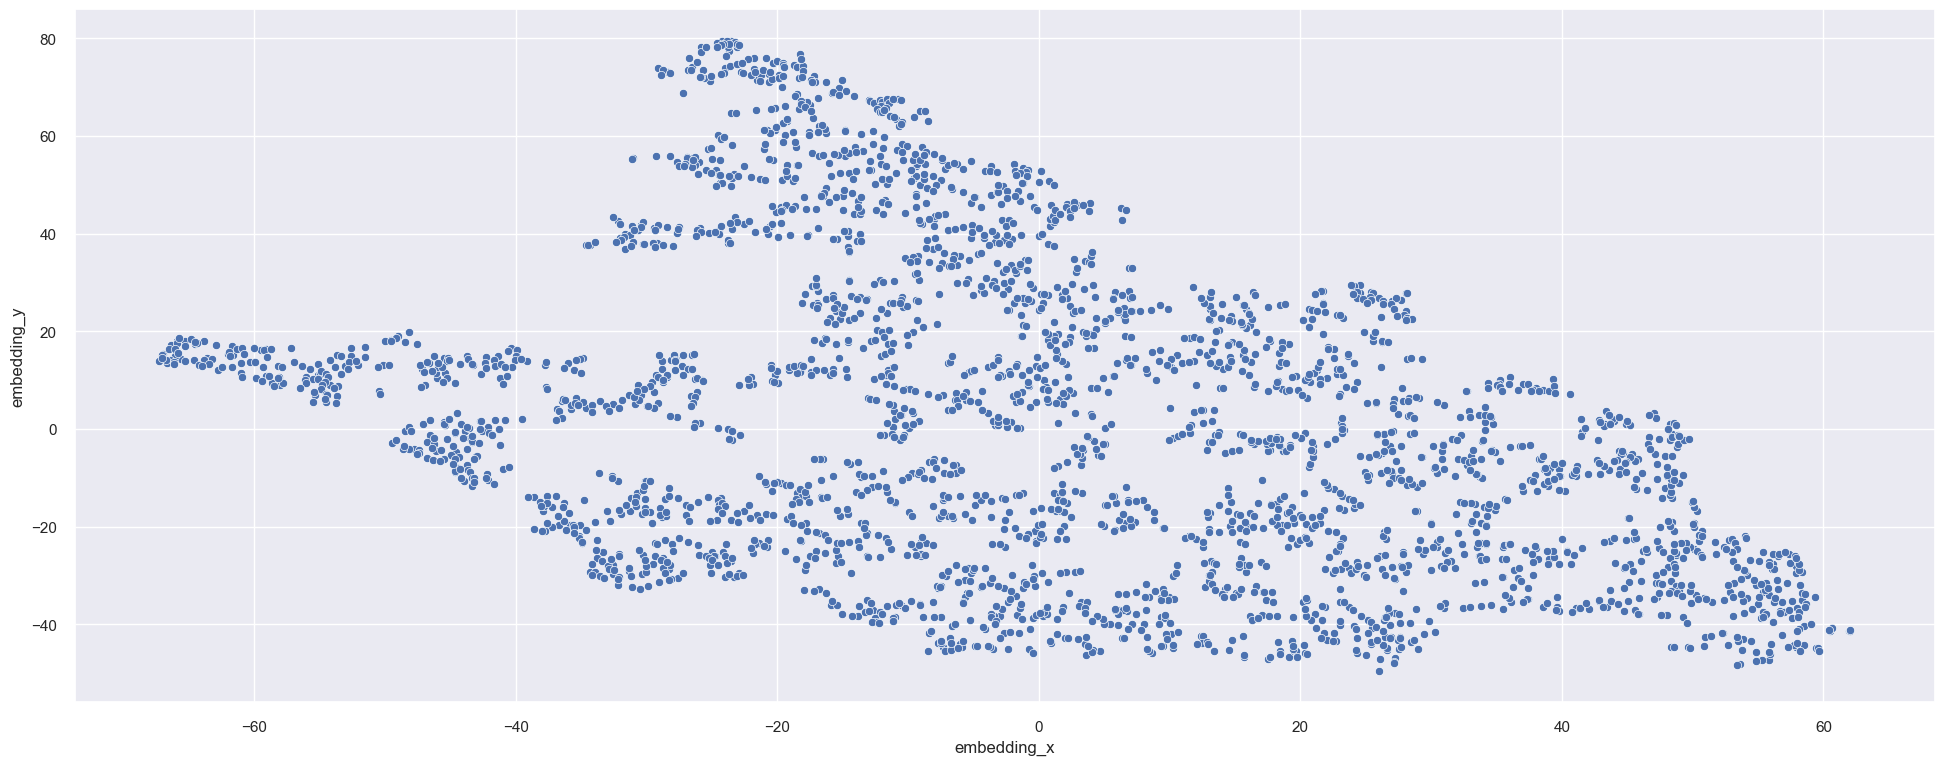

In [62]:
reducer = TSNE(n_components = 2, n_jobs = -1, random_state = 42)
embedding = reducer.fit_transform(X)

# embedding
df_pca['embedding_x'] = embedding[:, 0]
df_pca['embedding_y'] = embedding[:, 1]

# plot UMAP
sns.scatterplot(x = 'embedding_x', y = 'embedding_y', data = df_pca)

### 4.3.4. Tree-Based Embedding

In [63]:
# training dataset
X = df4.drop(columns = ['customer_id', 'gross_revenue'], axis = 1)
y = df4['gross_revenue']

# model definition
rf_model = en.RandomForestRegressor(n_estimators = 100, random_state = 42)

# model training
rf_model.fit(X, y)

RandomForestRegressor(random_state=42)

In [64]:
df_leaf = pd.DataFrame(rf_model.apply(X))

In [65]:
X.shape

(2968, 10)

In [66]:
df_leaf.shape

(2968, 100)

In [67]:
df_leaf.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
0,2991,3177,3323,3337,2283,3147,3227,3130,3165,3364,3153,3309,3146,3188,2780,3205,3016,3174,3124,3294,3062,3081,2905,3299,3352,3323,3269,2862,3089,3041,3308,3382,3374,3337,2956,3248,3409,3135,2960,3028,3278,3203,3222,3134,3177,3143,3287,3334,3345,3141,3108,2920,3084,3391,3379,3202,3169,3414,2925,2977,3422,2887,3336,3255,2713,3042,3301,3327,3131,3304,3343,2990,2701,2967,3117,3160,2965,3104,3217,3048,3236,3323,3137,3053,3285,3098,3285,3196,3133,3271,3185,3178,3179,3059,3044,3115,3186,2823,3355,3291
1,2961,2928,3042,2970,2753,3131,2924,2830,3120,2905,3107,2566,2550,3112,2749,3126,2975,3046,3067,2832,2953,3025,2735,2852,3015,2915,2841,2781,3075,3031,2869,3015,2968,2751,2920,2972,2972,2764,3055,3023,2972,2789,3195,3110,3117,2761,2912,2933,2980,3111,3176,3045,3061,2955,2980,2962,3127,3012,2896,2957,2994,2852,2900,2875,3000,3030,3000,2904,3056,2916,2957,2970,3148,2927,3043,2786,2901,3070,3165,3024,2924,2893,2984,2574,2909,3088,2933,3151,3092,2850,2549,2887,2882,3024,3146,3011,2920,2799,2965,2824
2,3633,3605,3586,3411,3569,3657,3629,3549,3680,3615,3635,3578,3540,3651,3561,3566,3583,3644,3551,3470,3522,3638,3605,3526,3577,3646,3574,3603,3593,3702,3432,3671,3598,3634,3574,3614,3542,3521,3598,3491,3656,3403,3633,3509,3535,3603,3425,3649,3631,3554,3632,3503,3571,3612,3683,3629,3610,3651,3570,3591,3614,3588,3583,3689,3453,3622,3661,3493,3552,3608,3588,3427,3577,3605,3549,3558,3599,3563,3534,3494,3431,3457,3567,3428,3555,3597,3581,3698,3594,3564,3594,3440,3560,3482,3598,3454,3526,3620,3565,3647
3,1275,1412,1758,1489,2018,1452,2102,1444,1652,1717,2033,2296,1343,1597,1523,1990,1884,1597,1933,1413,1833,1436,1459,1500,1145,1473,1506,1527,1983,1310,1944,1511,1503,1452,1533,1537,2161,2204,1660,1483,1492,1470,1461,1765,1526,1495,1465,1396,1356,1665,1805,1493,1345,2217,2093,1492,1551,1739,1297,2126,1483,1902,1887,1744,1479,1489,1369,1759,1035,1358,2301,1580,2180,2172,1272,2040,2032,1493,1914,1467,1910,1406,1495,1638,1482,1490,2055,1343,1659,1538,1875,1719,2027,1881,1921,2241,1450,1196,1988,2096
4,355,719,578,691,146,710,734,679,191,197,578,722,665,194,569,611,575,419,554,413,576,710,416,200,632,211,438,206,147,729,704,201,211,203,232,722,594,202,706,972,516,872,217,593,894,676,284,604,692,607,588,185,755,399,80,550,700,666,719,603,231,742,188,206,671,457,481,592,457,202,711,229,549,624,720,199,720,181,110,227,106,696,758,218,682,176,306,725,686,808,332,193,583,544,196,156,189,705,706,175


<AxesSubplot: xlabel='embedding_x', ylabel='embedding_y'>

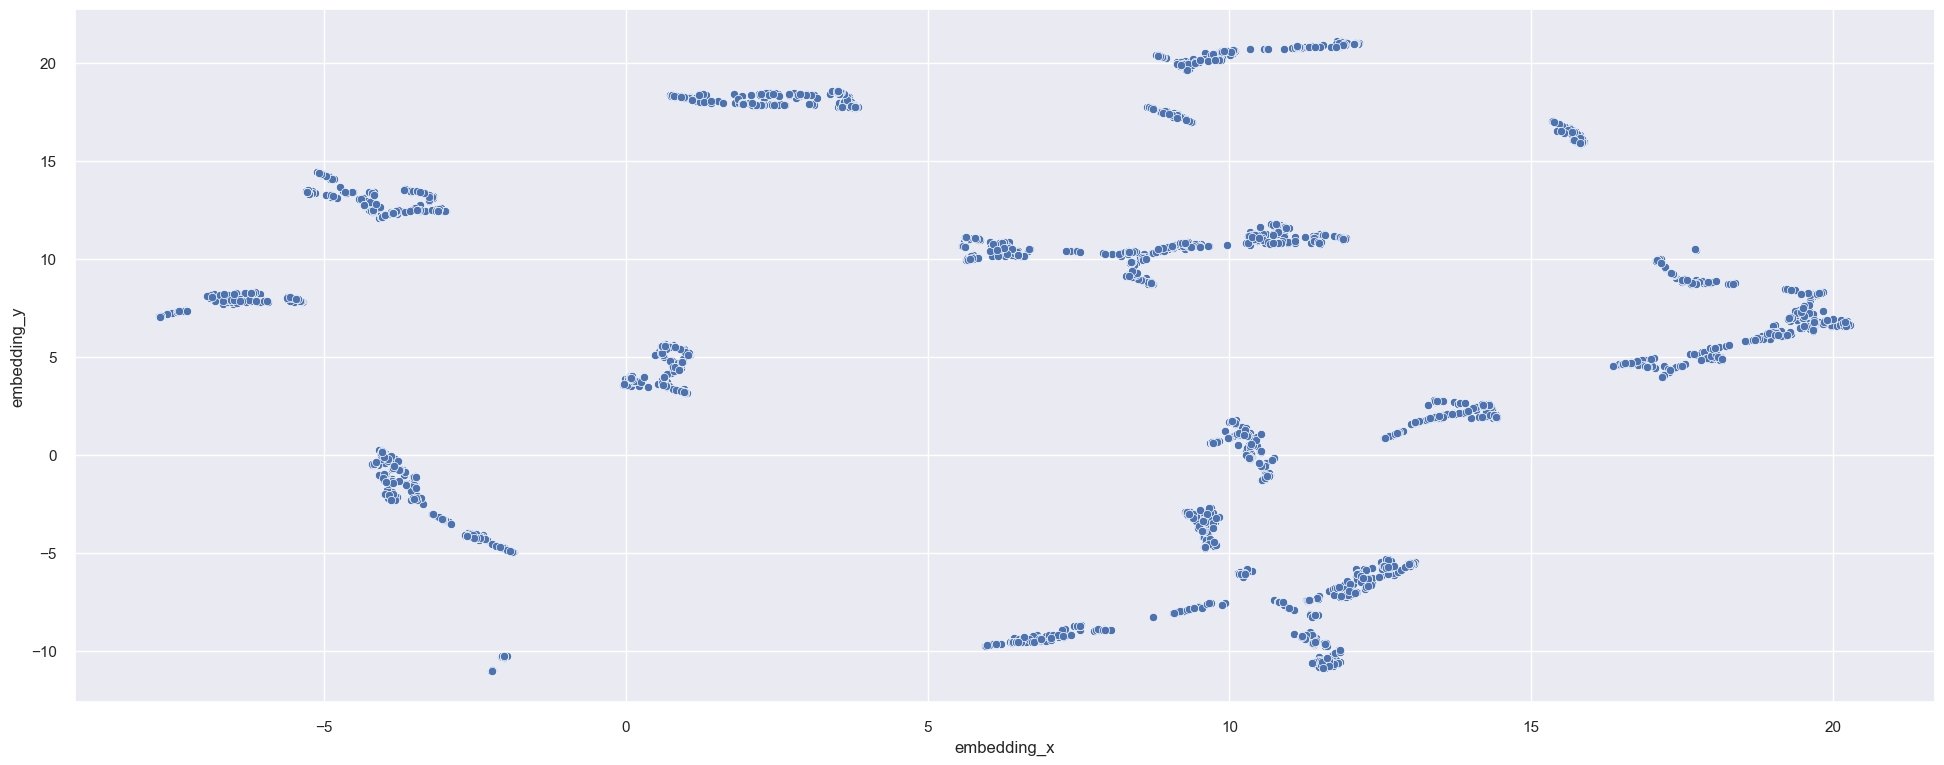

In [68]:
# Reducer dimensionality
reducer = umap.UMAP(random_state = 42)
embedding = reducer.fit_transform(df_leaf)

# embedding
df_pca['embedding_x'] = embedding[:, 0]
df_pca['embedding_y'] = embedding[:, 1]

# plot UMAP
sns.scatterplot(x = 'embedding_x', y = 'embedding_y', data = df_pca)

# <font color = 'red'> 5.0. Data Preparation </font>

In [69]:
df5 = df4.copy()

In [70]:
df5.columns

Index(['customer_id', 'gross_revenue', 'recency_days', 'qty_invoices',
       'qty_items', 'qty_products', 'avg_ticket', 'avg_recency_days',
       'frequency', 'qty_returns', 'avg_basket_size',
       'avg_unique_basket_size'],
      dtype='object')

In [71]:
# Standard Scaler
ss = pp.MinMaxScaler()

df5['gross_revenue'] = ss.fit_transform(df5[['gross_revenue']])
df5['recency_days'] = ss.fit_transform(df5[['recency_days']])
df5['qty_invoices'] = ss.fit_transform(df5[['qty_invoices']])
df5['qty_items'] = ss.fit_transform(df5[['qty_items']])
df5['qty_products'] = ss.fit_transform(df5[['qty_products']])
df5['avg_ticket'] = ss.fit_transform(df5[['avg_ticket']])
df5['avg_recency_days'] = ss.fit_transform(df5[['avg_recency_days']])
df5['frequency'] = ss.fit_transform(df5[['frequency']])
df5['qty_returns'] = ss.fit_transform(df5[['qty_returns']])
df5['avg_basket_size'] = ss.fit_transform(df5[['avg_basket_size']])
df5['avg_unique_basket_size'] = ss.fit_transform(df5[['avg_unique_basket_size']])

In [72]:
df5.head()

,customer_id,gross_revenue,recency_days,qty_invoices,qty_items,qty_products,avg_ticket,avg_recency_days,frequency,qty_returns,avg_basket_size,avg_unique_basket_size
0,17850,0.019292,0.997319,0.160976,0.008799,0.037770,0.003595,0.905479,1.000000,0.004438,0.008317,0.001614
1,13047,0.011559,0.150134,0.039024,0.007056,0.021692,0.003764,0.928082,0.001345,0.003883,0.025539,0.044307
2,12583,0.024000,0.005362,0.068293,0.025538,0.029476,0.006010,0.939212,0.002052,0.005547,0.055623,0.028594
3,13748,0.003375,0.254692,0.019512,0.002225,0.003445,0.007125,0.748858,0.000734,0.000000,0.014447,0.017774
4,15100,0.003116,0.892761,0.009756,0.000401,0.000255,0.065116,0.979178,0.003985,0.002441,0.004272,0.000515


# <font color = 'red'> 6.0. Feature Selection </font>

In [73]:
df6 = df5.copy()

# <font color = 'red'> 7.0. Hyperparameter Fine-Tunning </font>

In [74]:
X = df6.drop(columns = ['customer_id'])

In [75]:
X.head()

,gross_revenue,recency_days,qty_invoices,qty_items,qty_products,avg_ticket,avg_recency_days,frequency,qty_returns,avg_basket_size,avg_unique_basket_size
0,0.019292,0.997319,0.160976,0.008799,0.037770,0.003595,0.905479,1.000000,0.004438,0.008317,0.001614
1,0.011559,0.150134,0.039024,0.007056,0.021692,0.003764,0.928082,0.001345,0.003883,0.025539,0.044307
2,0.024000,0.005362,0.068293,0.025538,0.029476,0.006010,0.939212,0.002052,0.005547,0.055623,0.028594
3,0.003375,0.254692,0.019512,0.002225,0.003445,0.007125,0.748858,0.000734,0.000000,0.014447,0.017774
4,0.003116,0.892761,0.009756,0.000401,0.000255,0.065116,0.979178,0.003985,0.002441,0.004272,0.000515


In [76]:
clusters = [2, 3, 4, 5, 6, 7]

## 7.1. K-Means

In [80]:
kmeans_list = []
for k in clusters:
    # model definition
    kmeans_model = c.KMeans(n_clusters = k)
    
    # model training
    kmeans_model.fit(X)
    
    # model predict
    labels = kmeans_model.predict(X)
    
    # model performance
    sil = m.silhouette_score(X, labels, metric = 'euclidean')
    kmeans_list.append(sil)

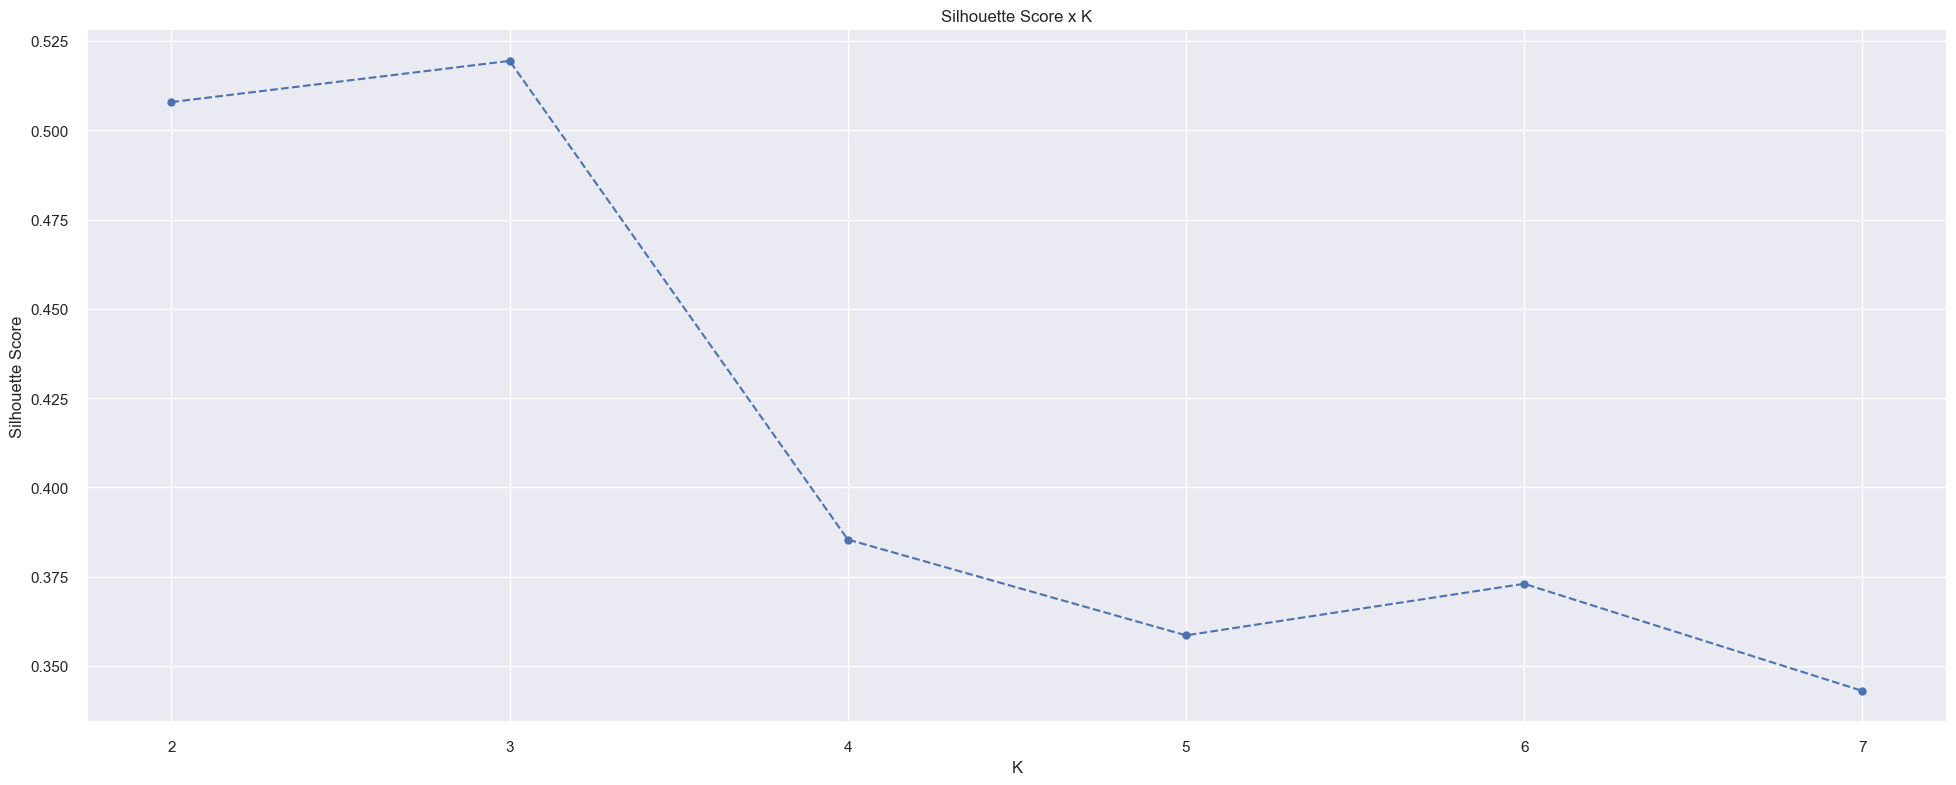

In [81]:
plt.plot(clusters, kmeans_list, linestyle = '--', marker = 'o', color = 'b')
plt.xlabel('K');
plt.ylabel('Silhouette Score');
plt.title('Silhouette Score x K');

## 7.2. GMM

In [82]:
gmm_list = []

for k in clusters:
    # model definition
    gmm_model = mx.GaussianMixture(n_components = k)
    
    # model training
    gmm_model.fit(X)
    
    # model predict
    labels = gmm_model.predict(X)
    
    # model performance
    sil = m.silhouette_score(X, labels, metric = 'euclidean')
    gmm_list.append(sil)

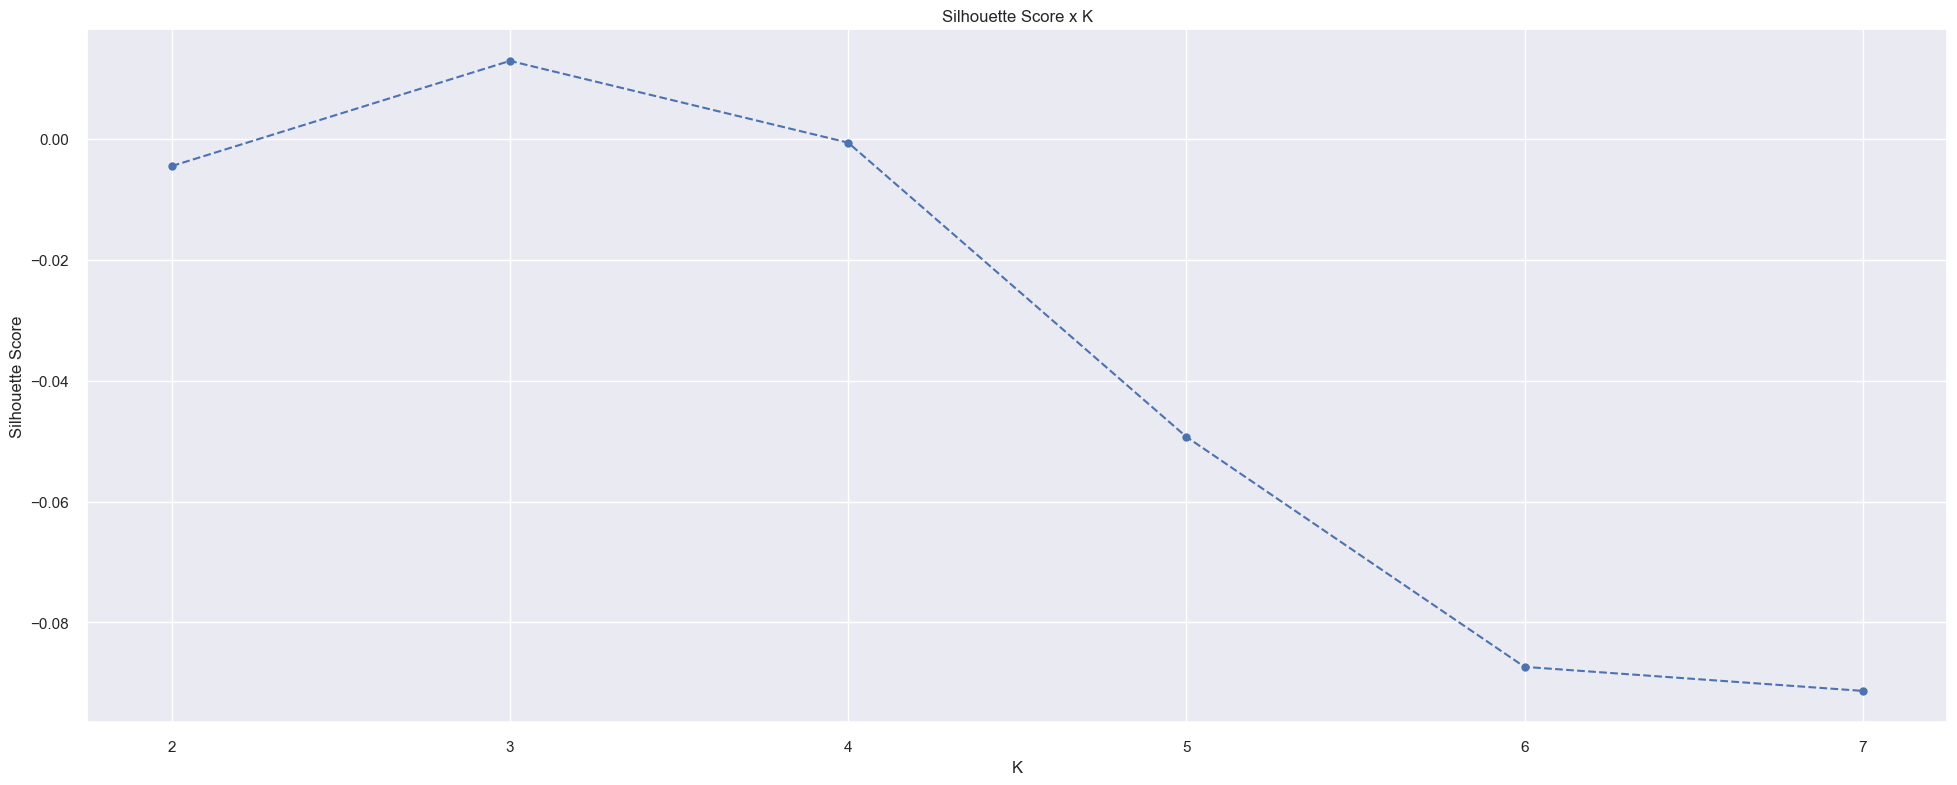

In [83]:
plt.plot(clusters, gmm_list, linestyle = '--', marker = 'o', color = 'b')
plt.xlabel('K');
plt.ylabel('Silhouette Score');
plt.title('Silhouette Score x K');

## 7.3. Hierarchical Clustering

In [84]:
hc_model = hc.linkage(X, 'ward')

[]

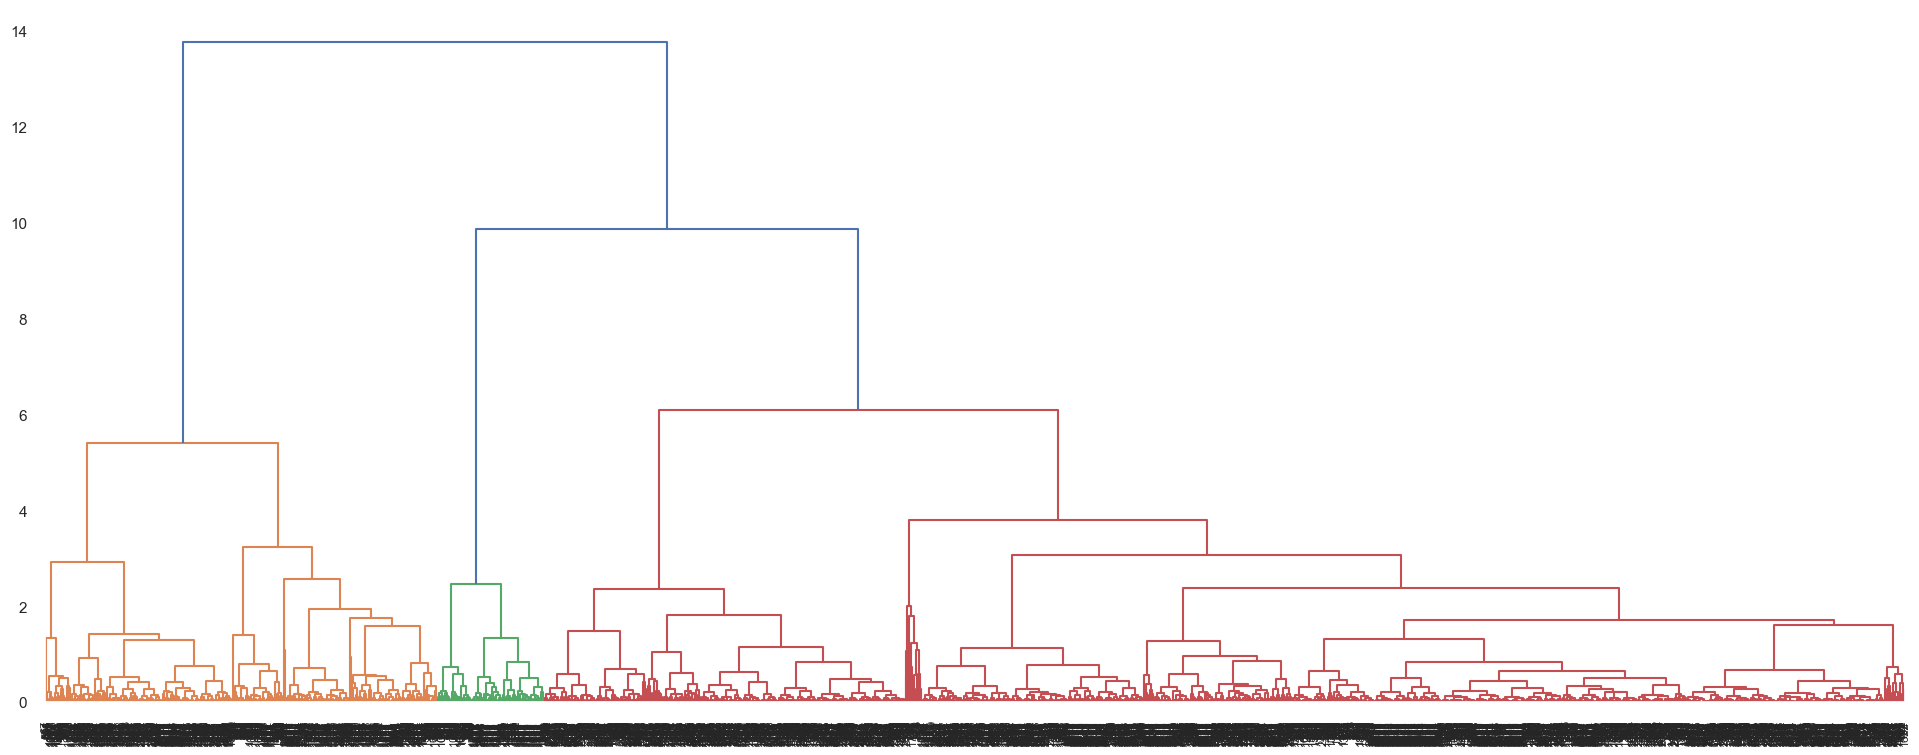

In [85]:
hc.dendrogram(hc_model, leaf_rotation = 90, leaf_font_size = 8)
plt.plot()

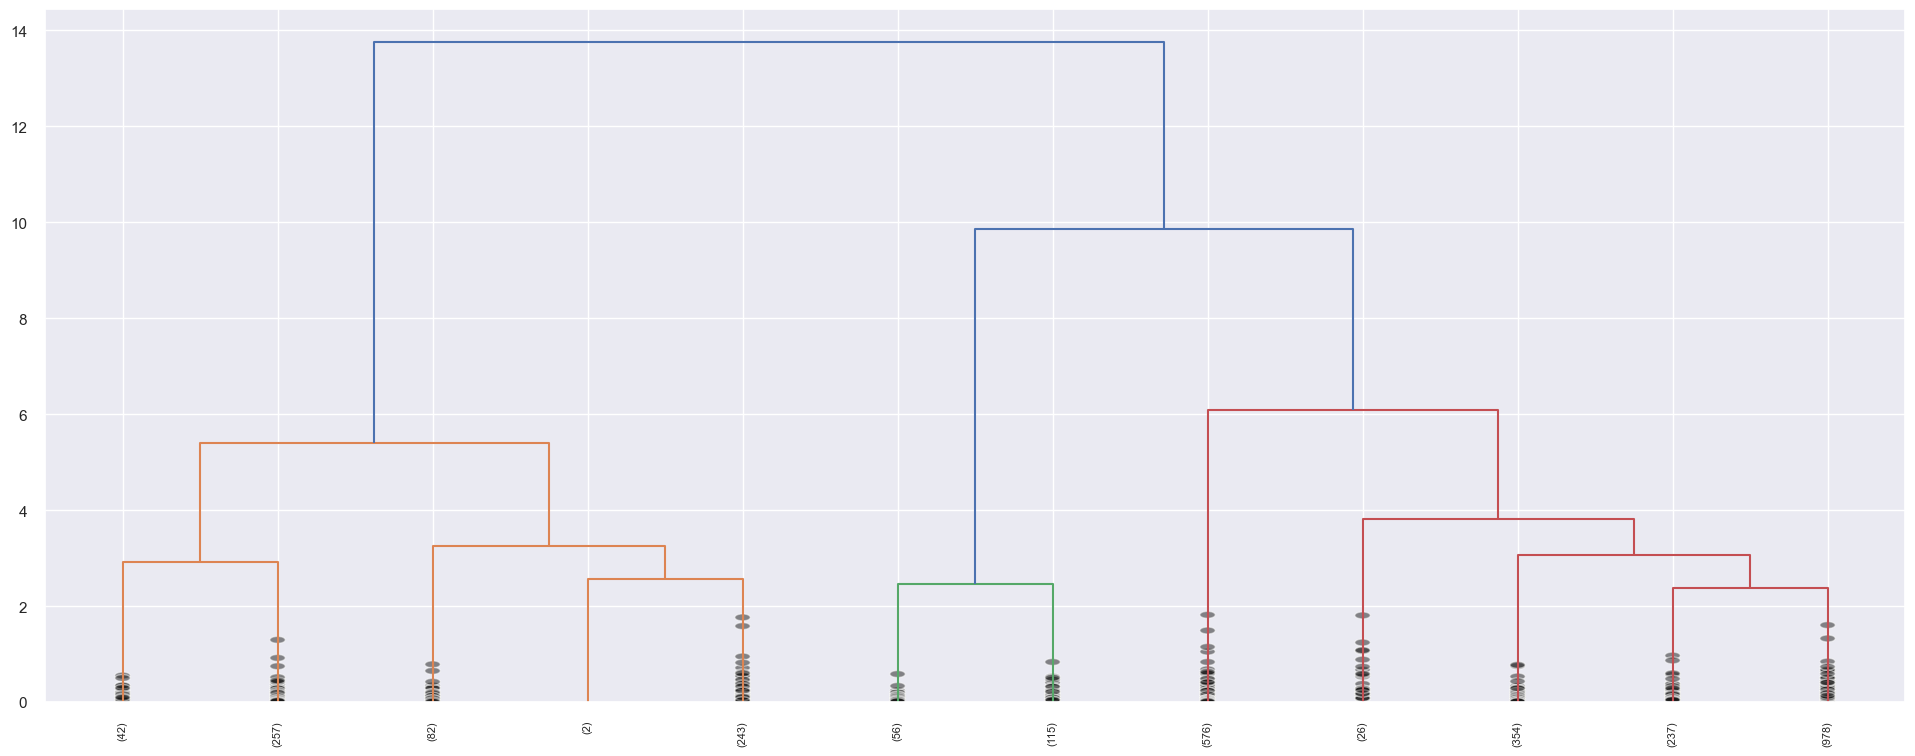

In [89]:
hc.dendrogram(hc_model, truncate_mode = 'lastp', p = 12, leaf_rotation = 90, leaf_font_size = 8, show_contracted = True)
plt.show()

### 7.3.1. HClustering Silhouette Score

In [94]:
hc_list = []

for k in clusters:
    # model definition & training with Scipy
    hc_model = hc.linkage(X, 'ward')

    # model predict
    labels = hc.fcluster(hc_model, k, criterion = 'maxclust')

    # metrics
    sil = m.silhouette_score(X, labels, metric = 'euclidean')
    hc_list.append(sil)

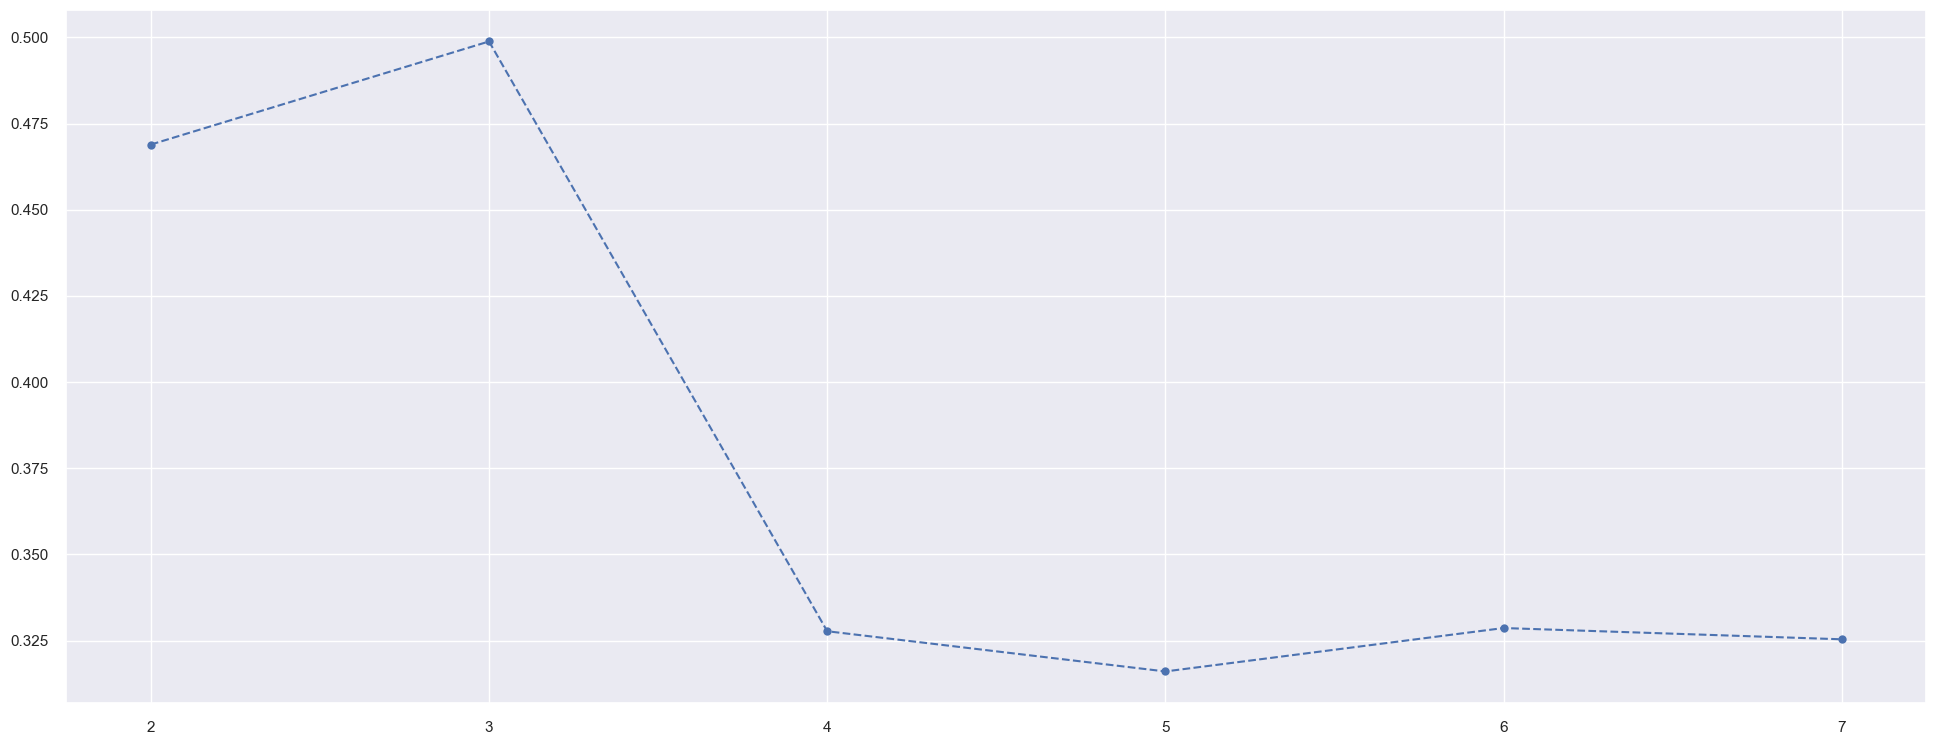

In [95]:
plt.plot(clusters, hc_list, linestyle = '--', marker = 'o', color = 'b')

## 7.4. DBSCAN

In [125]:
eps = 0.2
min_samples = 20

# model definition
dbscan_model = c.DBSCAN(eps = eps, min_samples = min_samples)

# model training & predict
labels = dbscan_model.fit_predict(X)

sil = m.silhouette_score(X, labels, metric = 'euclidean')
print('Silhouette Score: {}'.format(sil))
print('Number of Clusters: {}'.format(len(np.unique(labels))))
print(np.unique(labels))

Silhouette Score: 0.622034827461325
Number of Clusters: 2
[-1  0]


In [126]:
from sklearn.neighbors import NearestNeighbors

In [127]:
neighbors = NearestNeighbors(n_neighbors=min_samples).fit(X)
neighbors

NearestNeighbors(n_neighbors=20)

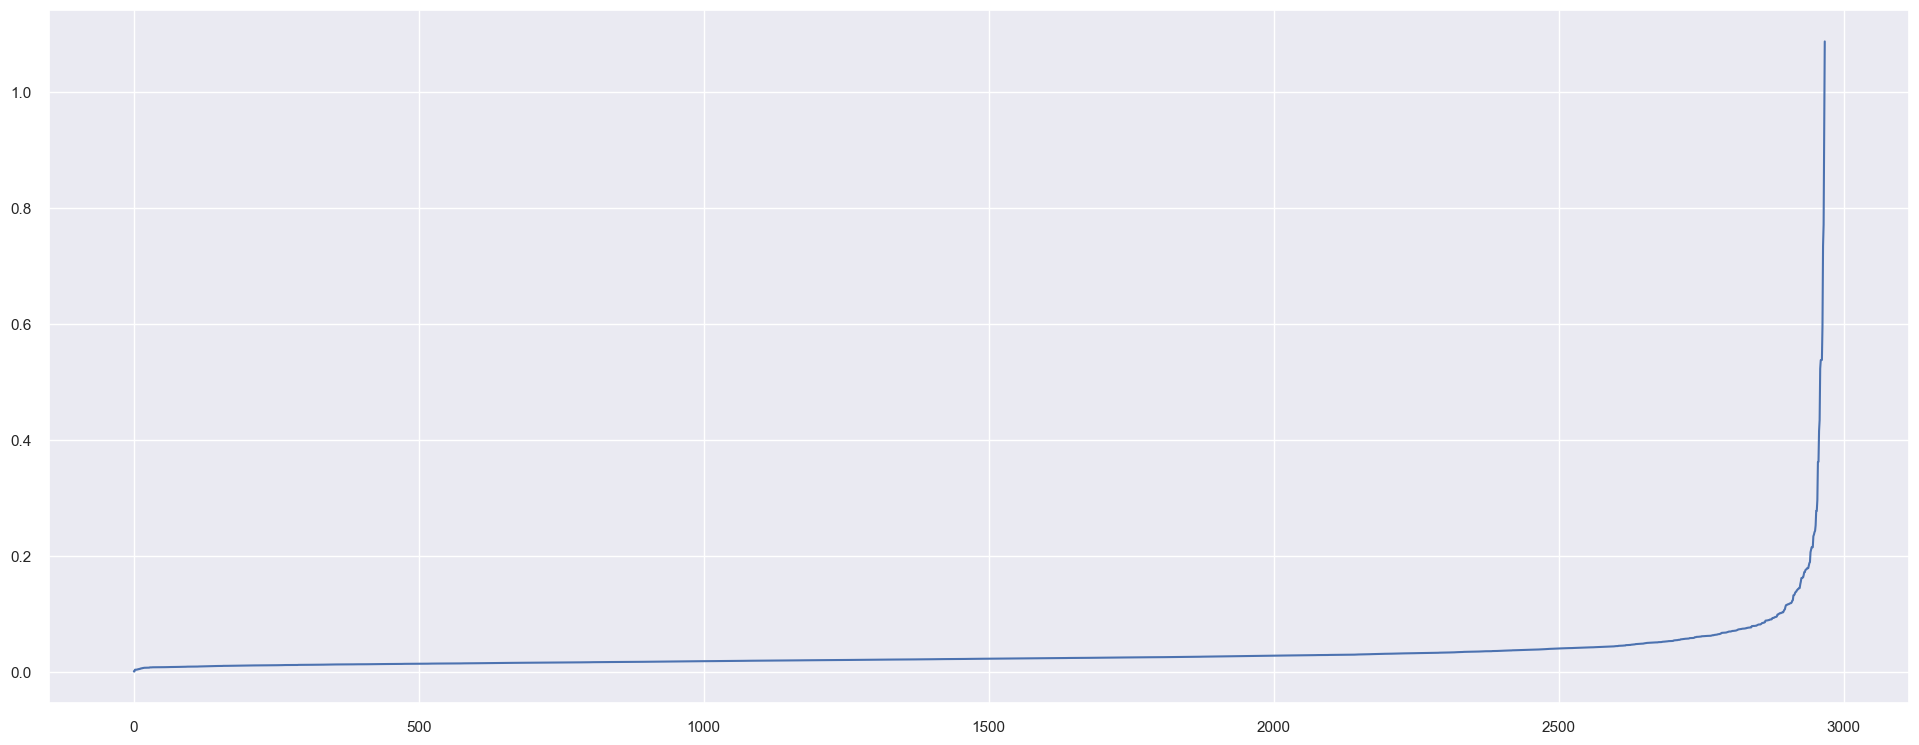

In [128]:
distances, indices = neighbors.kneighbors(X)
distances = np.sort(distances, axis = 0)
distances = distances[:, 1]
plt.plot(distances)

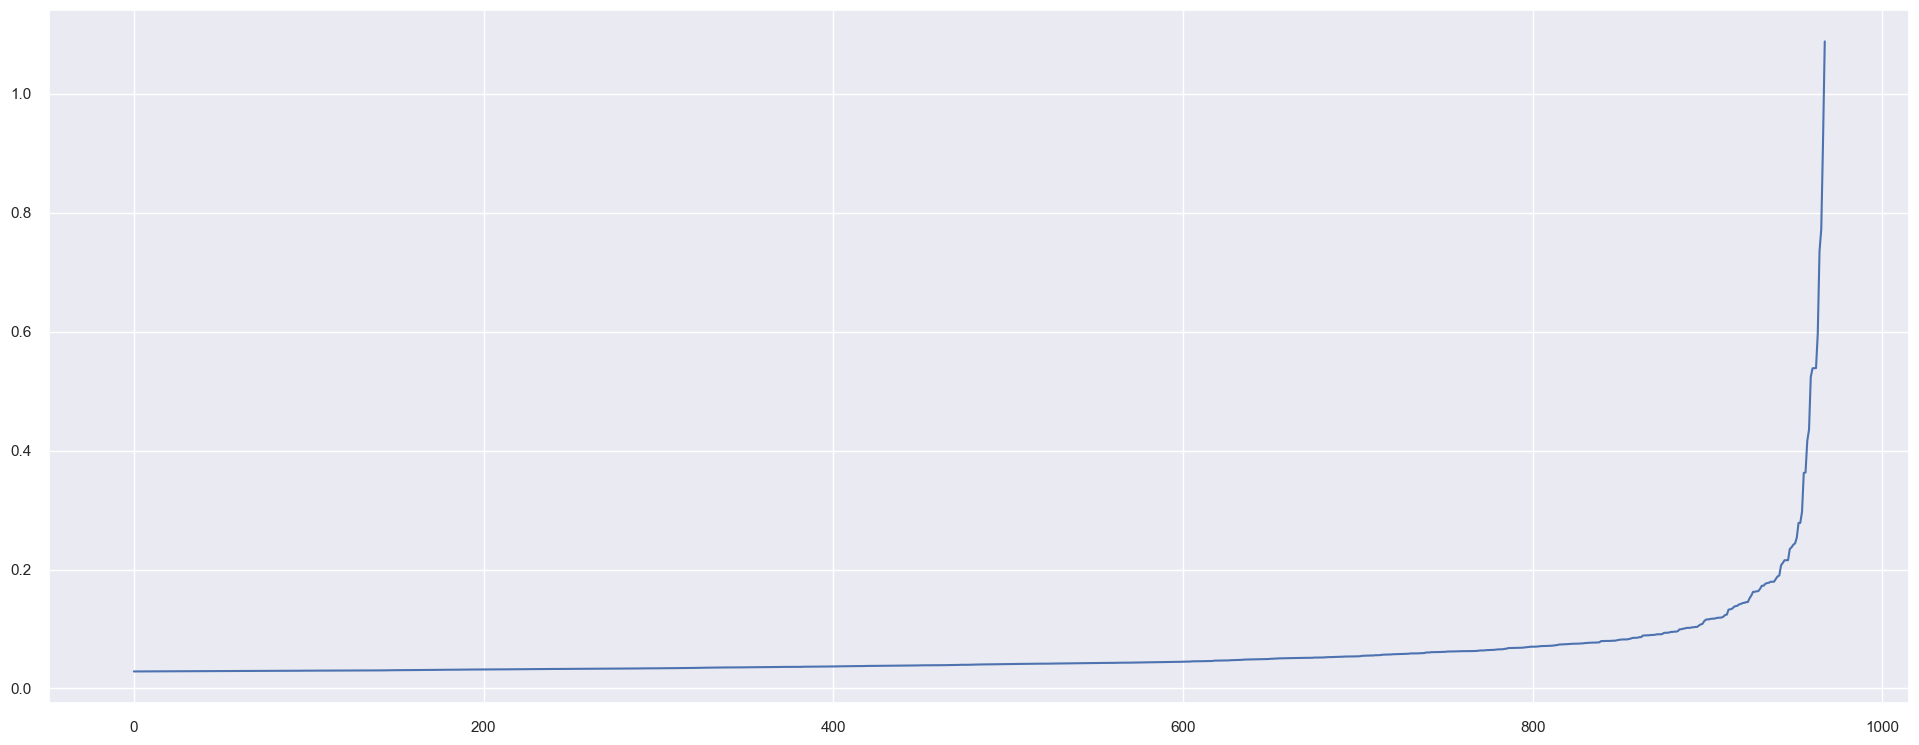

In [129]:
plt.plot(distances[2000:])

In [130]:
dbscan_list =[0.622034, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000]

## 7.5. Results

In [131]:
df_results = pd.DataFrame({'KMeans': kmeans_list,
                        'GMM': gmm_list,
                        'HC': hc_list,
                        'DBSCAN': dbscan_list}).T

df_results.columns = clusters

In [132]:
df_results.style.highlight_max(color = 'green', axis = 1)

,2,3,4,5,6,7
KMeans,0.507904,0.519431,0.385396,0.358559,0.373005,0.343009
GMM,-0.004519,0.012877,-0.000646,-0.049293,-0.087343,-0.091316
HC,0.468911,0.498824,0.327713,0.316046,0.328641,0.325372
DBSCAN,0.622034,0.000000,0.000000,0.000000,0.000000,0.000000


## 7.1. Silhouette Analysis

 For K = 2. Silhouette Score: 0.4689113070295039
 For K = 3. Silhouette Score: 0.49882430497442565
 For K = 4. Silhouette Score: 0.32771315437908355
 For K = 5. Silhouette Score: 0.316046375293321
 For K = 6. Silhouette Score: 0.32864056948138476
 For K = 7. Silhouette Score: 0.3253720291762707


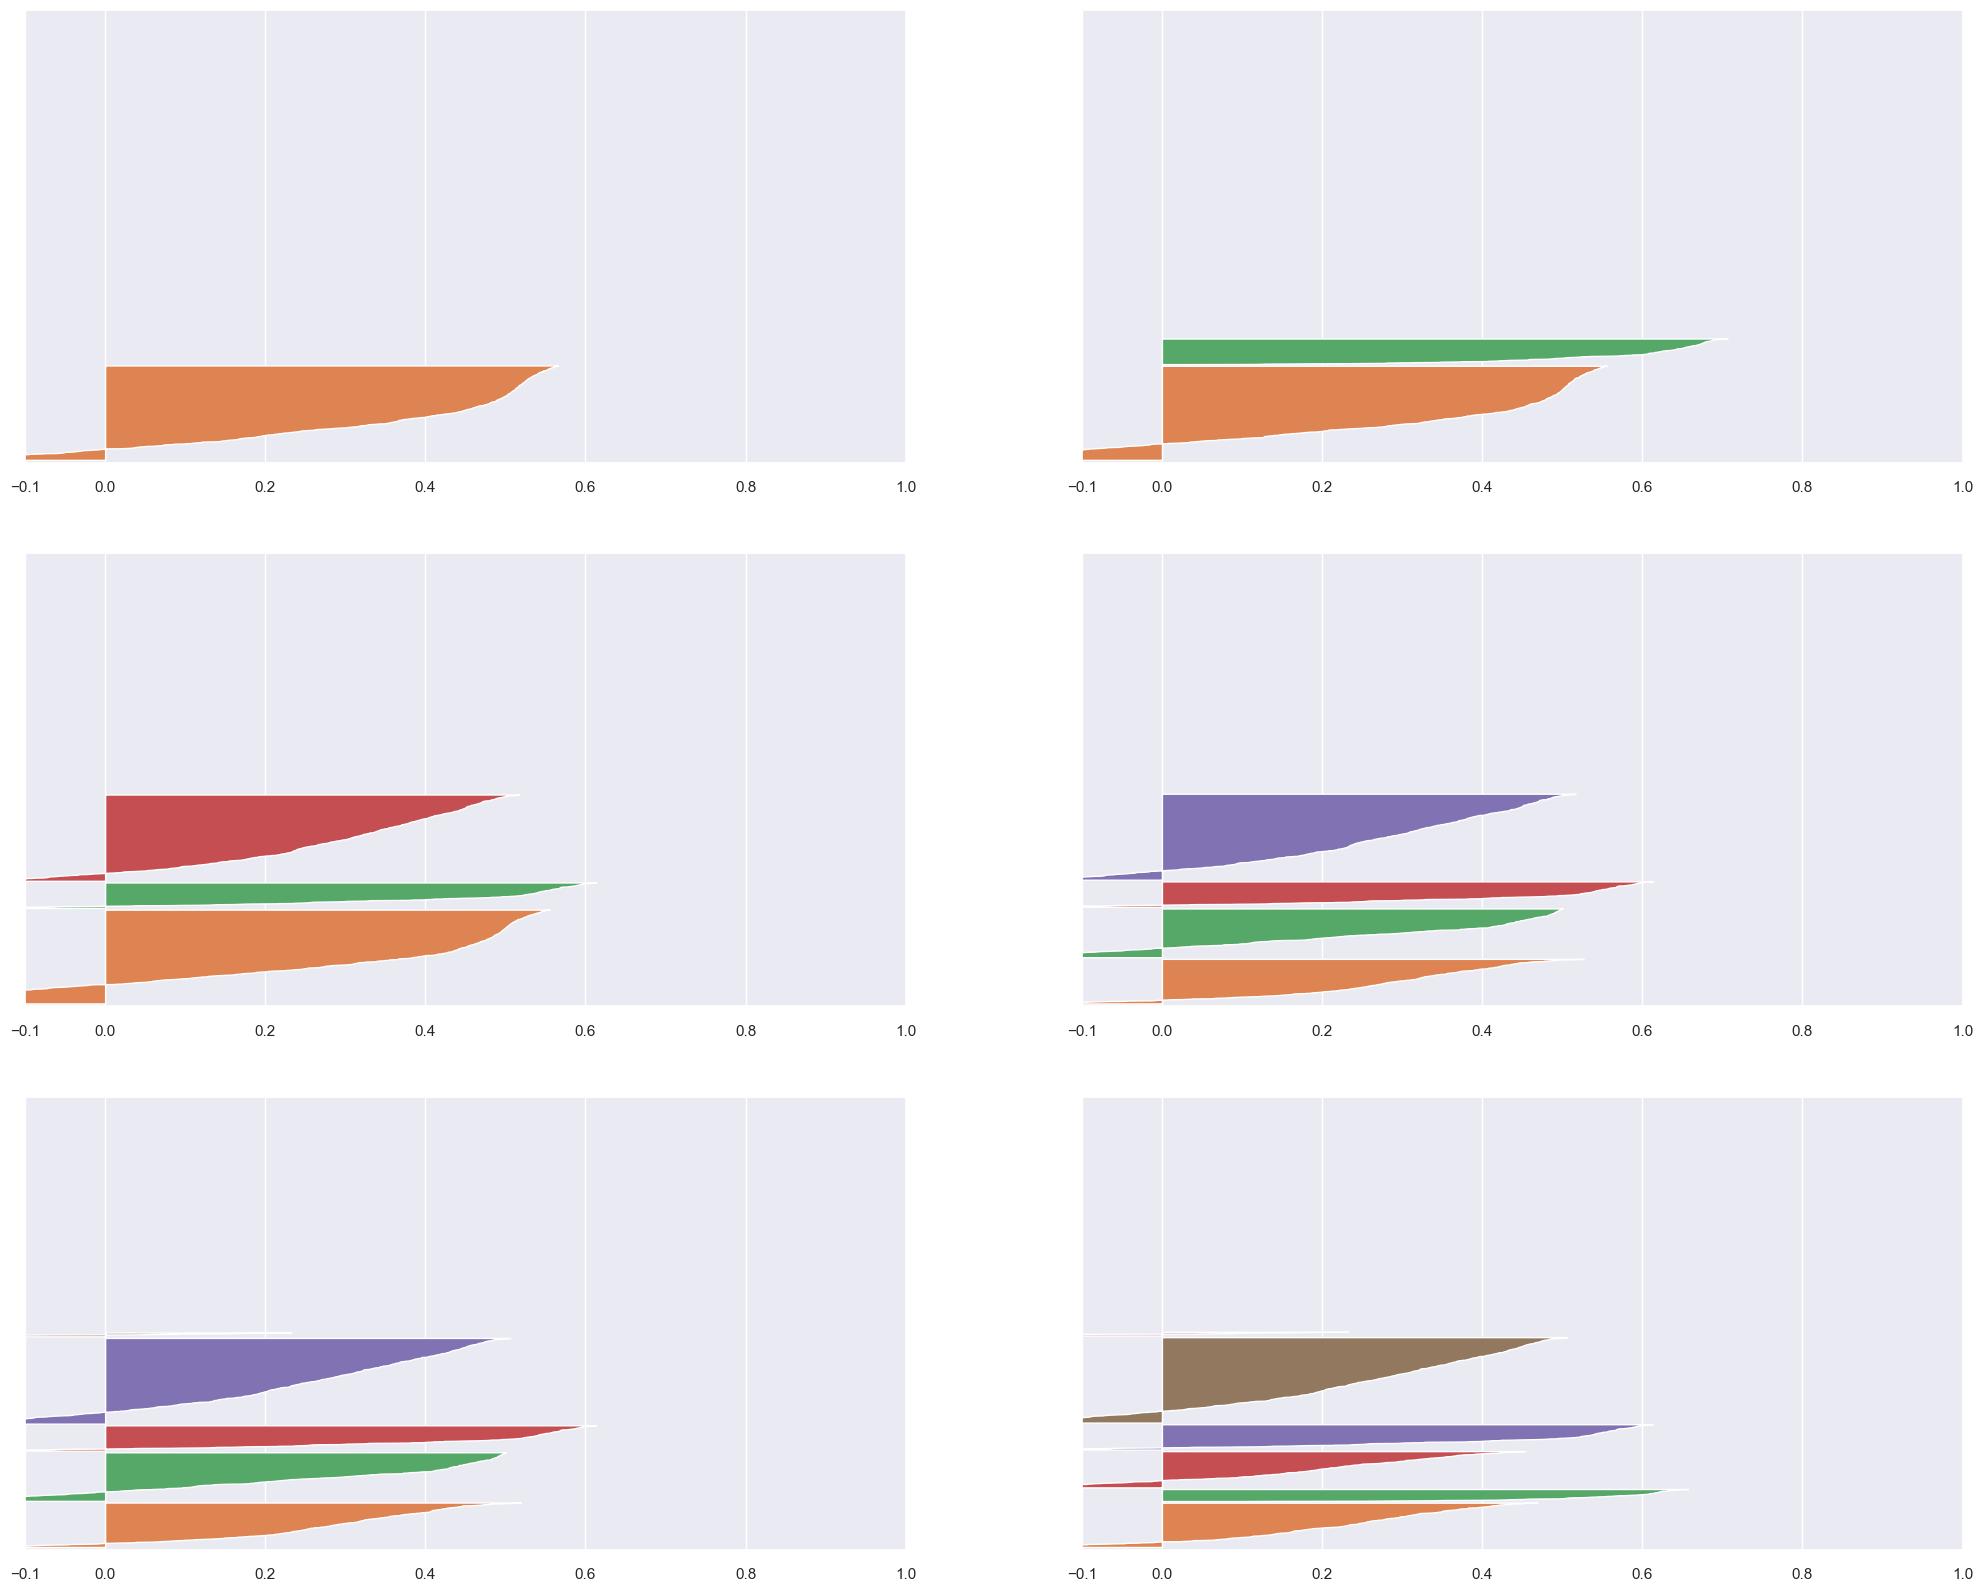

In [135]:
# Silhouette Analysis para outros modelos que não sejam o KMeans
fig, ax = plt.subplots( 3, 2 )
fig.set_size_inches( 25, 20 )

for k in clusters:
    q, mod = divmod( k, 2 )
    
    ax[q-1, mod].set_xlim( [ -0.1, 1] )
    ax[q-1, mod].set_ylim( [ 0, len( X ) + ( k+1 )*10] )
    
    # model definition & training
    hc_model = hc.linkage( X, 'ward' )

    # model predict
    labels = hc.fcluster( hc_model, k, criterion='maxclust' )

    # performance
    ss = m.silhouette_score( X, labels, metric='euclidean' )
    print( ' For K = {}. Silhouette Score: {}'.format( k, ss ) )

    samples_silhouette_values = m.silhouette_samples( X, labels )

    y_lower = 10
    for i in range( k ):

        # select clusters
        ith_samples_silhouette_values = samples_silhouette_values[ labels == i]
        
        # sort values
        ith_samples_silhouette_values.sort()

        # size clusters
        size_cluster_i = ith_samples_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        
        cmap = cm.get_cmap( 'Spectral' )
        color = cmap( i / k )

        ax[q-1, mod].fill_betweenx( np.arange( y_lower, y_upper ), 0, ith_samples_silhouette_values  )
        
        y_lower = y_upper + 10
        
    ax[q-1, mod].set_yticks([])
    ax[q-1, mod].set_xticks( [-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

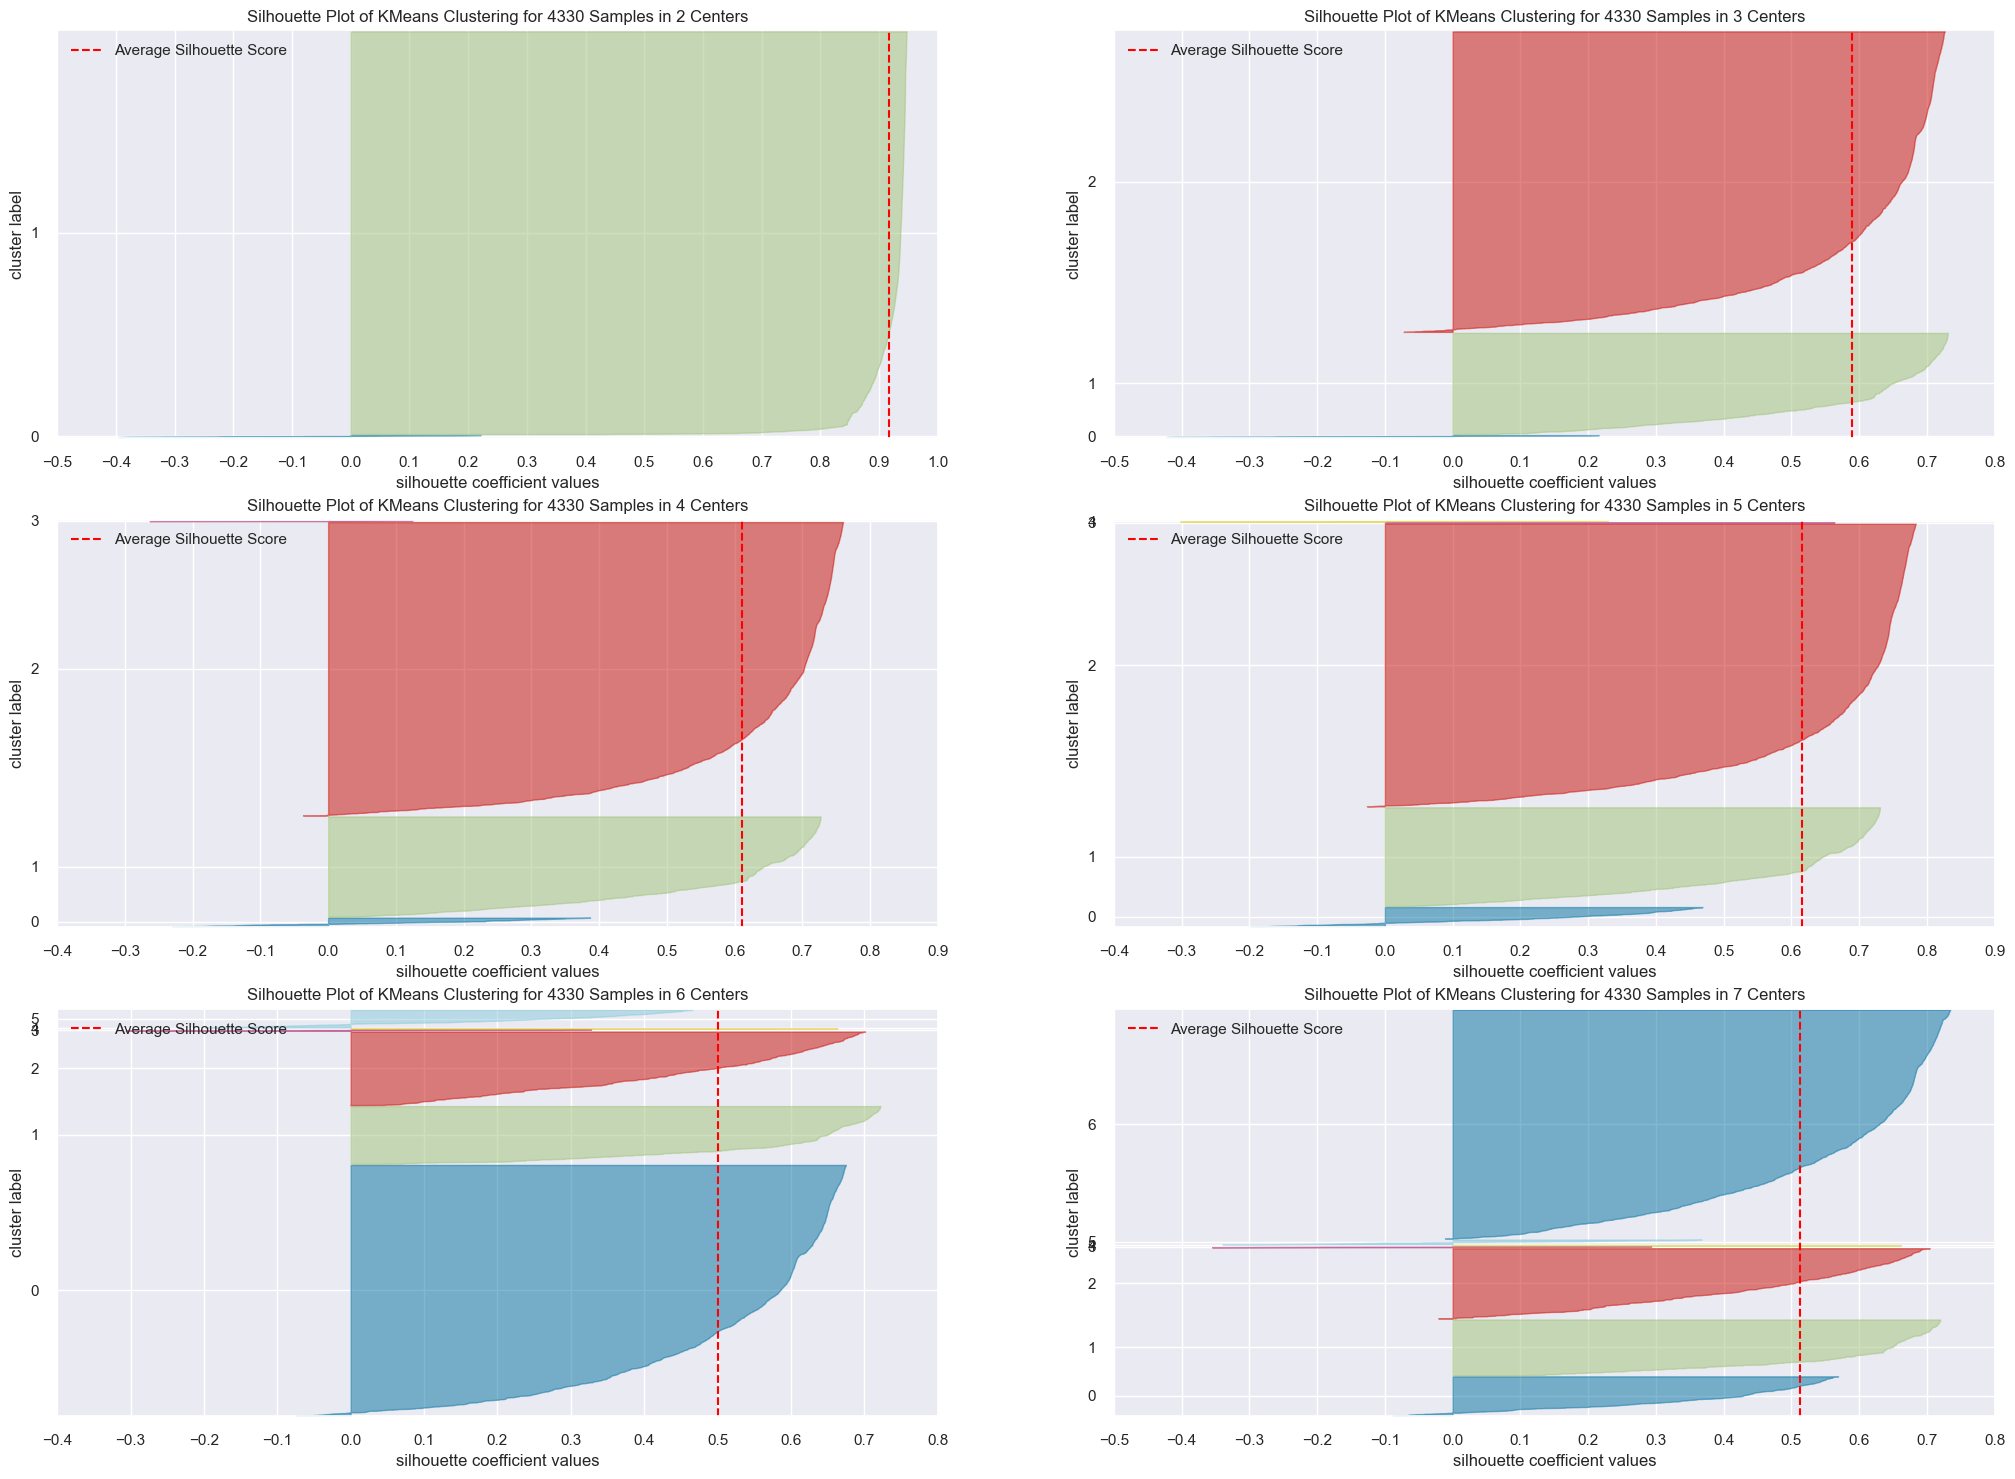

In [212]:
# Silhouette Analysis for KMeans

fig, ax = plt.subplots(3, 2, figsize = (25, 18))

for k in clusters:
    km = c.KMeans(n_clusters = k, init = 'random', n_init = 10, max_iter = 100, random_state = 42)
    q, mod = divmod(k, 2)
    
    visualizer = SilhouetteVisualizer(km, colors = 'yellowbrick', ax = ax[q-1][mod])
    visualizer.fit(X)
    visualizer.finalize()

# <font color = 'red'> 8.0. Model Training </font>

## 8.1. K-Means

In [213]:
# model definition
k = 3
kmeans = c.KMeans(init = 'random', n_clusters = k, n_init = 10, max_iter = 300)

# model training
kmeans.fit(X)

# clustering
labels = kmeans.labels_

## 8.2. Cluster Validation

In [214]:
# WSS (Within-Cluster Sum of Square)
print('WSS value: {}'.format(kmeans.inertia_))

# SS (Silhouette Score)
print('SS value: {}'.format(m.silhouette_score(X, labels, metric = 'euclidean')))

WSS value: 9404.844768603243
SS value: 0.5895273303328358


# <font color = 'red'> 9.0. Cluster Analysis </font>

In [216]:
df9 = df6.copy()

In [217]:
df9['cluster'] = labels
df9.head()

,customer_id,gross_revenue,recency_days,invoice_no,avg_ticket,cluster
0,17850,0.377179,2.791504,3.889207,-0.033935,2
1,13047,0.135378,-0.360996,0.620902,-0.033423,0
2,12583,0.524388,-0.899714,1.405296,-0.026618,0
3,13748,-0.120506,0.028079,0.097974,-0.023240,0
4,15100,-0.128600,2.402430,-0.163491,0.152447,2


## 9.1. Inspection

c:\Users\pgdem\anaconda3\envs\insiders\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


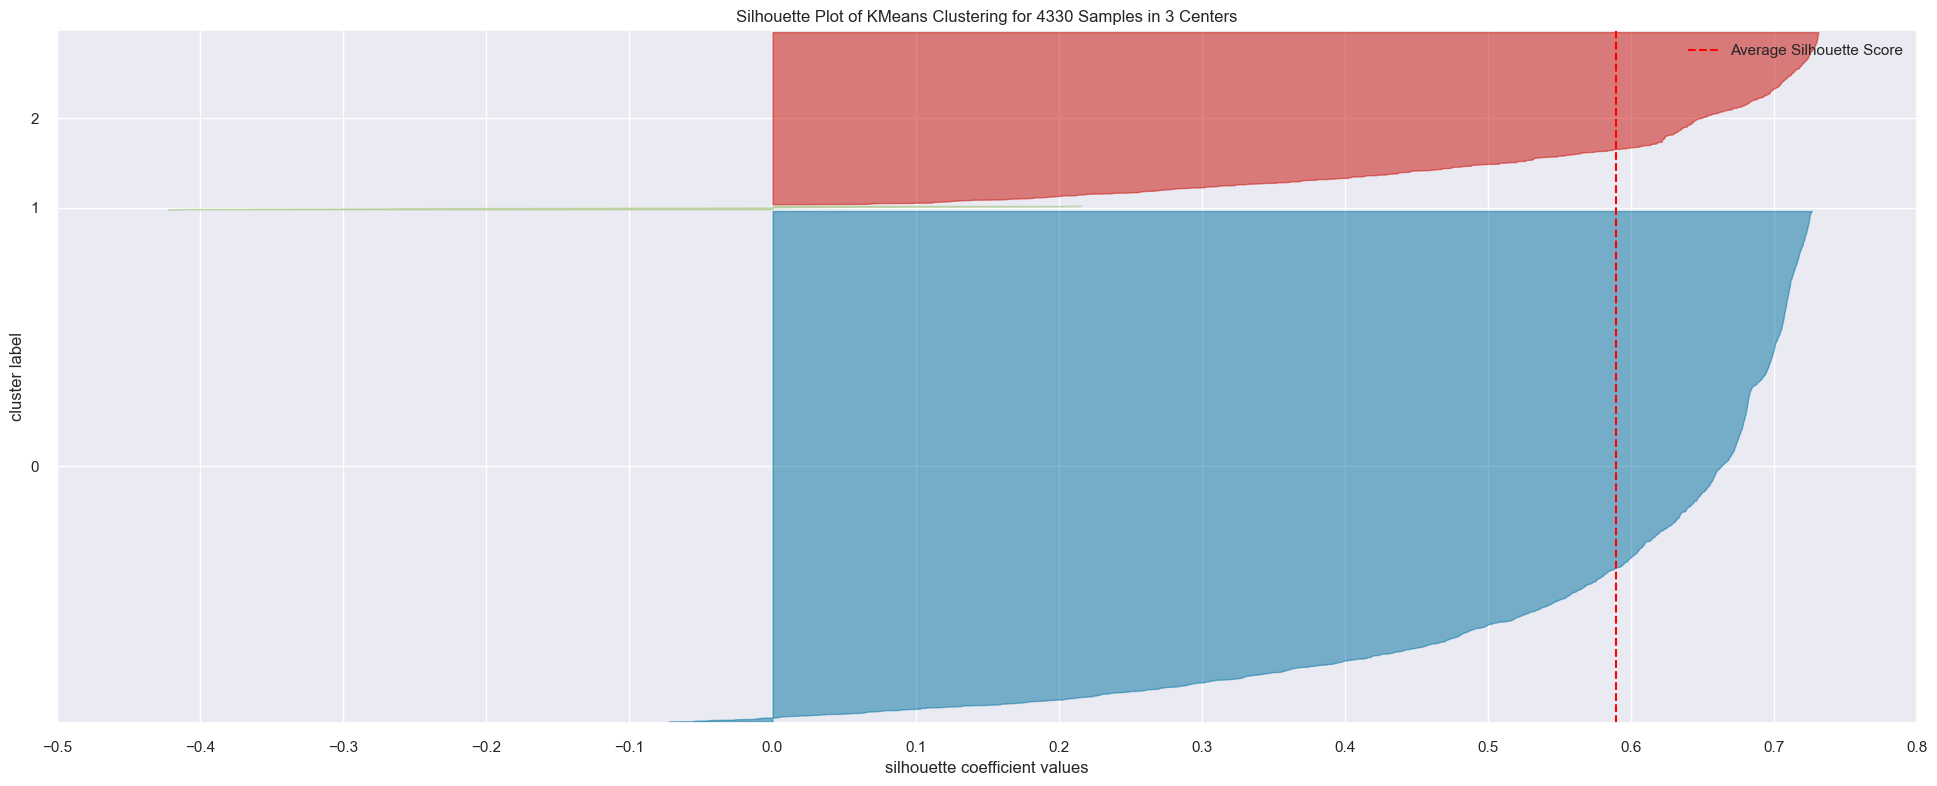

In [218]:
visualizer = SilhouetteVisualizer(kmeans, colors = 'yellowbrick')
visualizer.fit(X)
visualizer.finalize()

## 9.2. 2d plot

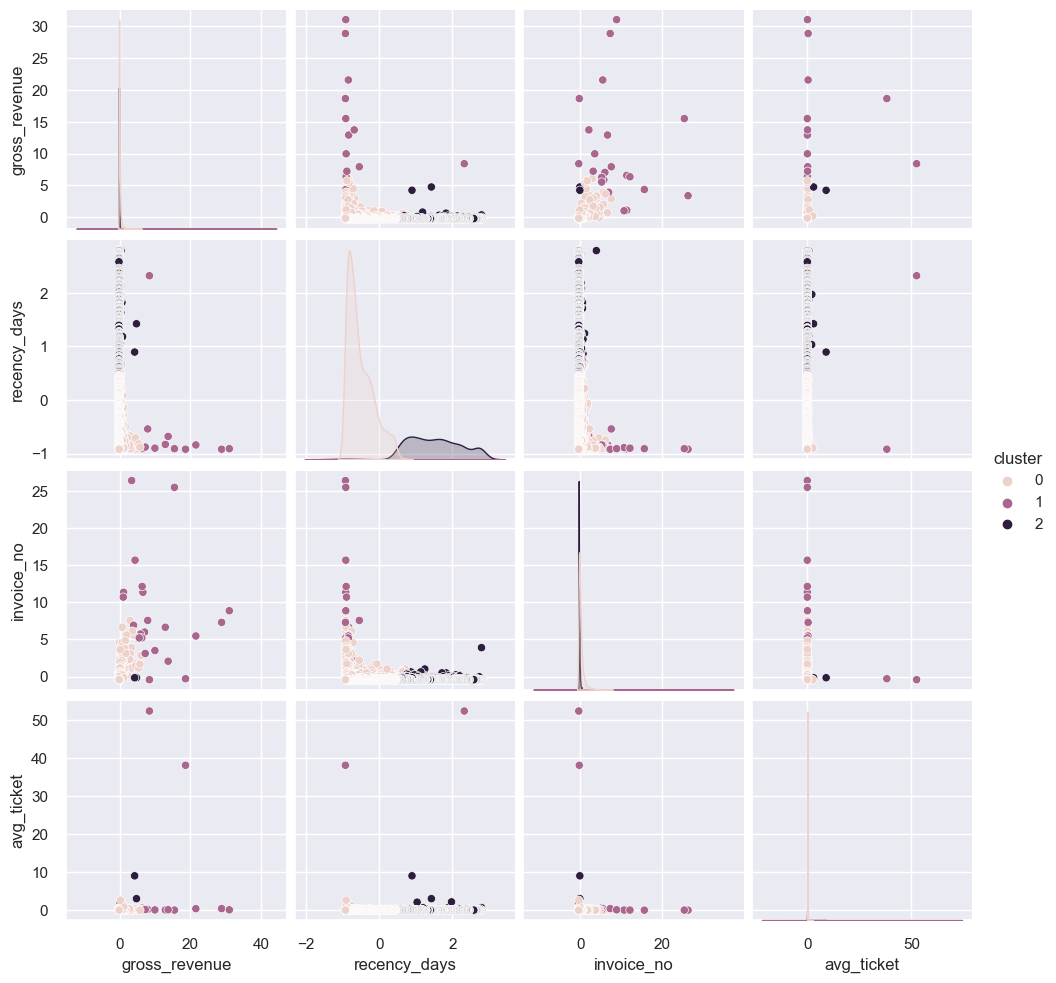

In [220]:
df_viz = df9.drop(columns = 'customer_id', axis = 1)
sns.pairplot(df_viz, hue = 'cluster')

## 9.3. UMAP

<AxesSubplot: xlabel='embedding_x', ylabel='embedding_y'>

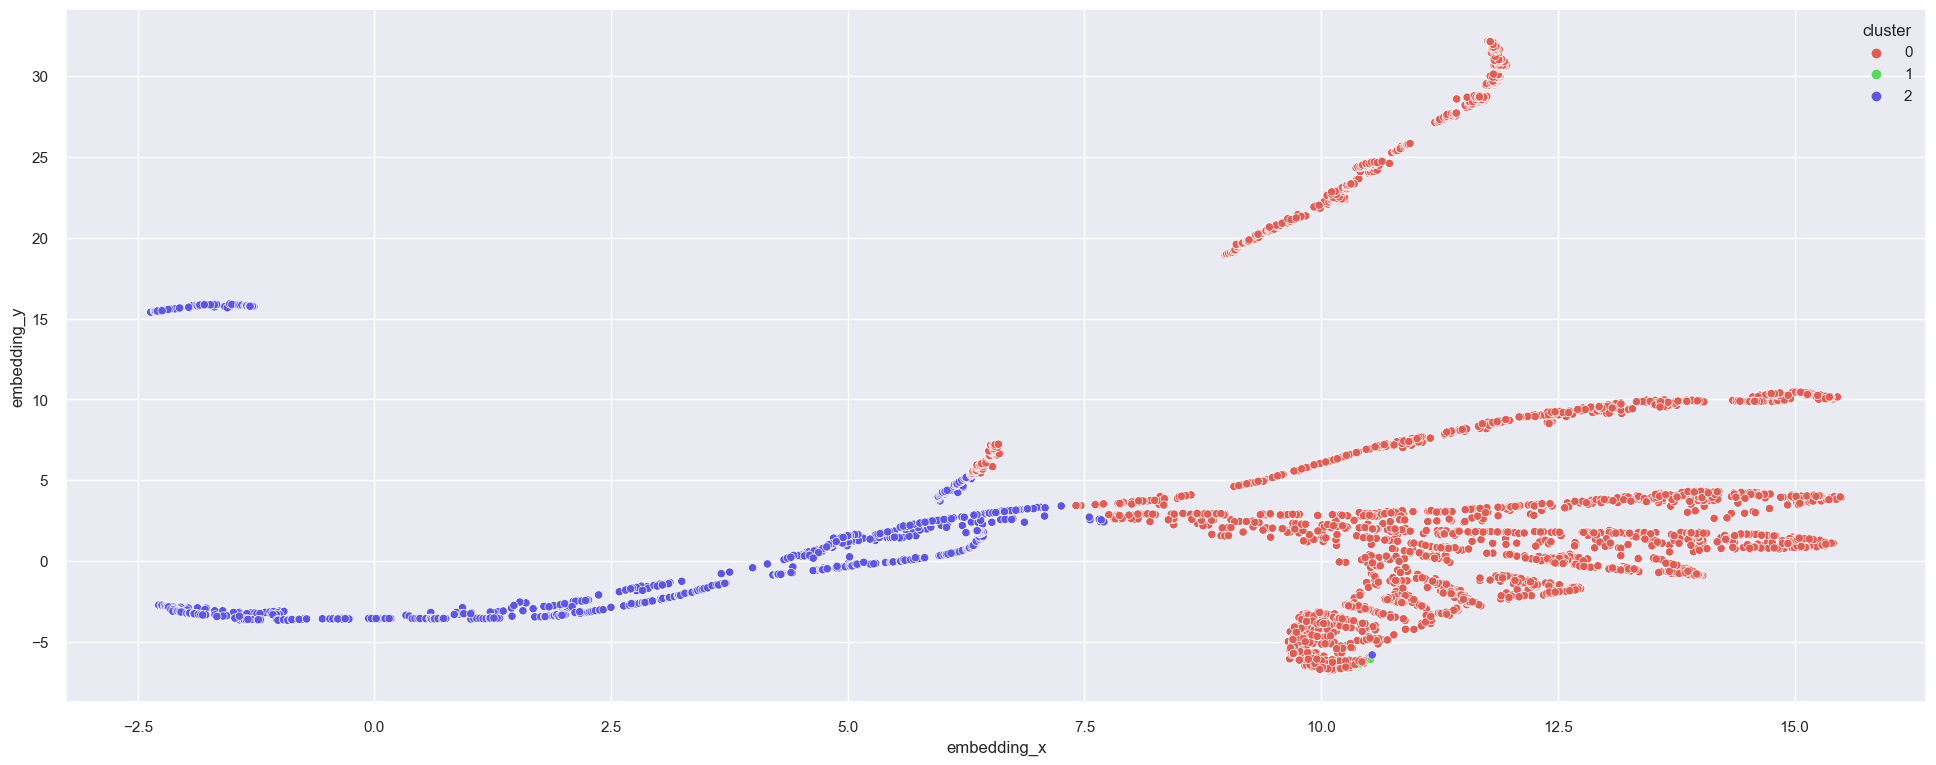

In [221]:
reducer = umap.UMAP(n_neighbors = 90, random_state = 42)
embedding = reducer.fit_transform(X)

# embedding
df_viz['embedding_x'] = embedding[:, 0]
df_viz['embedding_y'] = embedding[:, 1]

# plot UMAP
sns.scatterplot(x = 'embedding_x', y = 'embedding_y',
                hue = 'cluster',
                palette = sns.color_palette('hls', n_colors = len(df_viz['cluster'].unique())),
                data = df_viz)

## 9.2. Cluster Profile

In [222]:
df9.head()

,customer_id,gross_revenue,recency_days,invoice_no,avg_ticket,cluster
0,17850,0.377179,2.791504,3.889207,-0.033935,2
1,13047,0.135378,-0.360996,0.620902,-0.033423,0
2,12583,0.524388,-0.899714,1.405296,-0.026618,0
3,13748,-0.120506,0.028079,0.097974,-0.023240,0
4,15100,-0.128600,2.402430,-0.163491,0.152447,2


In [223]:
# Number of customers
df_cluster = df9[['customer_id', 'cluster']].groupby('cluster').count().reset_index()
df_cluster['perc_customer'] = 100 * (df_cluster['customer_id'] / df_cluster['customer_id'].sum())

# Avg Gross Revenue
df_avg_gross_revenue = df9[['gross_revenue', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_gross_revenue, how = 'inner', on = 'cluster')

# Avg Recency days
df_avg_recency_days = df9[['recency_days', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_recency_days, how = 'inner', on = 'cluster')

# Avg invoice_no
df_invoice_no = df9[['invoice_no', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_invoice_no, how = 'inner', on = 'cluster')

# Avg Ticket
df_ticket = df9[['avg_ticket', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_ticket, how = 'inner', on = 'cluster')

df_cluster

,cluster,customer_id,perc_customer,gross_revenue,recency_days,invoice_no,avg_ticket
0,0,3222,74.411085,-0.015103,-0.513785,0.060442,-0.025682
1,1,22,0.508083,10.335282,-0.722409,8.441064,4.189464
2,2,1086,25.080831,-0.164562,1.538959,-0.350320,-0.008675


### Cluster 00:
- Número de Customers: 267 (6%)
- Recência em média: 20 dias
- Compras em média: 19 compras
- Ticket médio: US$ 62.78
- Receita em média: US$ 8089.02

### Cluster 01: 
- Número de Customers: 28 (0.64%)
- Recência em média: 6 dias
- Compras em média: 58 compras
- Ticket médio: US$ 162.86
- Receita em média: US$ 42614.38

### Cluster 02:
- Número de Customers: 6 (0.13%)
- Recência em média: 7 dias
- Compras em média: 89 compras
- Ticket médio: US$ 253.62
- Receita em média: US$ 182181.98

### Cluster 03:
- Número de Customers: 4071 (93%)
- Recência em média: 96 dias
- Compras em média: 4 compras
- Ticket médio: US$ 25.35
- Receita em média: US$ 946.69 

# <font color = 'red'> 10.0. Deploy to Production </font>